<a id="index"></a>

# Index

Content:

* [0. Functions for later usage](#section0)
    - [0.0 Import libraries](#section00)
    - [0.1 Function 1: display_filtered_imagess](#section01)
    - [0.2 Function 2: evaluate_neural_network](#section02)
    - [0.3 Function 3: calculate_combined_misclassification_info](#section03)
    - [Identifying the device (either CPU or GPU) used with Keras & Tensorflow](#section04)
* [1. We detect the file encoding](#section1)
* [2. We load our built-in functions for EDA](#section2)
* [3. We load the dataset and perfom the EDA](#section3)
    - [3.1 We understand the dataset structure, missing values and unique values for each variable](#section31)
    - [3.2. We understand the images pixels size](#section32)
    - [3.3. We visualise the variables of our dataset](#section33)
* [4- We print some pictures from our dataset to understand its content](#section4)
* [5. Preparing the data for later usage in a neural network.](#section5)
* [6. We train our first model: a single layer perceptron. Model 1](#section6)
    - [6.1. We define the architecture of the first model. Model 1](#section61)
    - [6.2. We dig deeper into the model features. Model 1](#section62)
    - [6.3. We train our model. Model 1](#section63)
    - [6.4. Training time. Model 1](#section64)
    - [6.5. Model evaluation. Model 1](#section65)
    - [6.6. Visual inspection of missclassified pictures. Model 1](#section66)
    - [6.7. We train our model. Model 1.2.](#section67)
    - [6.4. Training time. Model 1.2](#section68)
    - [6.5. Model evaluation. Model 1.2](#section69)
* [7. We train our second model by tuning the hyper-parameters. Model 2](#section7)
    - [7.1 Model definition with hyper-parameters. Model 2](#section71)
    - [7.2 We instantiate the keras tuner with BayesianOptimization tuning with Gaussian process. Model 2](#section72)
    - [7.3 We train our model with the best hyper-parameters identified previously. Model 2 ](#section73)
    - [7.4 We evaluate our model. Model 2 ](#section74)
    - [7.5 We analyse the misclassification. Model 2 ](#section74)
* [8. We train our first RESNET Neural Network](#section8)

    


    


    

    



    

 

# 0. Functions for later usage <a id="section0"></a>

* [Go back to index](#index)


### 0.0 Import libraries <a id="section00"></a>

* [Go back to index](#index)

In [1]:
#!pip install kaggle

In [2]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from colorama import Back, Fore
import inspect
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.utils import plot_model
import inspect
import chardet
import sys
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,precision_recall_curve, roc_curve, auc
import seaborn as sns
import os
import sys
import urllib.request

### 0.1 Function 1: display_filtered_images <a id="section01"></a>

* [Go back to index](#index)

In [3]:
def display_filtered_images(df, age=None, ethnicity=None, gender=None, num_images=8, figsize=(20, 4)):
    """
    Display images filtered by age, ethnicity, and gender.
    
    Parameters:
    - df: DataFrame containing the image data and labels.
    - age: Filter for the age of the individuals (int or None).
    - ethnicity: Filter for the ethnicity of the individuals (int or None).
    - gender: Filter for the gender of the individuals (int or None).
    - num_images: Number of images to display.
    - figsize: Size of the figure.
    """
    
    # Apply filters
    filtered_df = df
    if age is not None:
        filtered_df = filtered_df[filtered_df['age'] == age]
    if ethnicity is not None:
        filtered_df = filtered_df[filtered_df['ethnicity'] == ethnicity]
    if gender is not None:
        filtered_df = filtered_df[filtered_df['gender'] == gender]
    
    # Ensure we don't try to display more images than available after filtering
    num_images = min(len(filtered_df), num_images)
    
    # Set up the plot
    fig, axes = plt.subplots(1, num_images, figsize=figsize)
    for i in range(num_images):
        # Directly use the pixel array if it's already in the correct format
        img_array = filtered_df.iloc[i]['pixels']
        if isinstance(img_array, np.ndarray):
            img_array = img_array.reshape(48, 48)  # Use directly if it's a numpy array
        else:
            img_array = img_array.numpy().reshape(48, 48)  # Convert to numpy array and then reshape
        ax = axes[i] if num_images > 1 else axes  # Handle case of num_images == 1
        # Display the image
        ax.imshow(img_array, cmap='gray')
        # Optionally, set a title with more information
        ax.set_title(f"Age: {filtered_df.iloc[i]['age']}\nEthnicity: {filtered_df.iloc[i]['ethnicity']}\nGender: {filtered_df.iloc[i]['gender']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()


### 0.2 Function 2: evaluate_neural_network <a id="section02"></a>

* [Go back to index](#index)

In [137]:
def evaluate_neural_network(model, val_dataset, history):
    # Predict the labels for the validation set
    y_pred_probs = model.predict(val_dataset)
    y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

    # Extract true labels from the validation dataset
    y_true = np.concatenate([np.array([y.numpy()]) for x, y in val_dataset.unbatch()], axis=0)

    # Print the classification report for all metrics
    print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Set up the subplot grid
    fig, axs = plt.subplots(3, 2, figsize=(14, 15))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[0, 0])
    axs[0, 0].set_title('Confusion Matrix')
    axs[0, 0].set_xlabel('Predicted')
    axs[0, 0].set_ylabel('True')

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
    axs[0, 1].plot(recall, precision, marker='.')
    axs[0, 1].set_title('Precision-Recall Curve')
    axs[0, 1].set_xlabel('Recall')
    axs[0, 1].set_ylabel('Precision')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    axs[1, 0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    axs[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[1, 0].set_xlabel('False Positive Rate')
    axs[1, 0].set_ylabel('True Positive Rate')
    axs[1, 0].set_title('Receiver Operating Characteristic')
    axs[1, 0].legend(loc="lower right")

    # Training & validation accuracy values
    axs[1, 1].plot(history.history['binary_accuracy'])
    axs[1, 1].plot(history.history['val_binary_accuracy'])
    axs[1, 1].set_title('Model Binary Accuracy')
    axs[1, 1].set_ylabel('Binary Accuracy')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['Train', 'Val'], loc='upper left')

    # Training & validation loss values
    axs[2, 0].plot(history.history['loss'])
    axs[2, 0].plot(history.history['val_loss'])
    axs[2, 0].set_title('Model Loss')
    axs[2, 0].set_ylabel('Loss')
    axs[2, 0].set_xlabel('Epoch')
    axs[2, 0].legend(['Train', 'Val'], loc='upper left')

    plt.tight_layout()
    plt.show()

# To use this function, call it with the appropriate model, validation dataset, and training history:
# evaluate_neural_network(model_v4, val_dataset_1, history)


### 0.3 Function 3: calculate_combined_misclassification_info <a id="section03"></a>

* [Go back to index](#index)


This function displays the absolute and relative volumes of missclassified instances/pictures broken down by age, gender and ethnicity.

In [5]:
def calculate_combined_misclassification_info(y_true, y_pred, data, category_names, age_bucket_size=5):
    """
    Calculate and print the misclassification rates and distribution for each label in each category,
    with ages bucketed into specified tranches.

    Parameters:
    - y_true: array-like of true labels
    - y_pred: array-like of predicted labels
    - data: DataFrame containing the category labels
    - category_names: list of column names in the DataFrame that are categories
    - age_bucket_size: size of the age buckets (default is 5 years)
    """
    # Initialize dictionaries to count total and misclassified instances per label
    total_counts = {name: defaultdict(int) for name in category_names}
    misclassified_counts = {name: defaultdict(int) for name in category_names}

    # Function to bucket the age
    def bucket_age(age):
        return f"{age // age_bucket_size * age_bucket_size}-{(age // age_bucket_size + 1) * age_bucket_size - 1}"

    # Iterate over the dataset and populate the counts
    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        for name in category_names:
            category_value = data.iloc[i][name]
            if name == 'age':
                category_value = bucket_age(category_value)
                
            total_counts[name][category_value] += 1
            if true != pred:
                misclassified_counts[name][category_value] += 1

    # Now calculate and print the misclassification rates and distribution
    for name in category_names:
        print(f"\n{name} - Misclassification rates:")
        for category_value, count in sorted(total_counts[name].items()):
            misclassified = misclassified_counts[name][category_value]
            total = count
            percentage = (misclassified / total) * 100 if total > 0 else 0
            print(f"  {category_value}: Total = {total}, Misclassified = {misclassified} ({percentage:.2f}%)")

        print(f"\n{name} - Misclassification distribution:")
        total_misclassified = sum(misclassified_counts[name].values())
        for category_value, misclassified in sorted(misclassified_counts[name].items()):
            distribution_percentage = (misclassified / total_misclassified) * 100 if total_misclassified > 0 else 0
            print(f"  {category_value}: Misclassified = {misclassified} ({distribution_percentage:.2f}%) of Total Misclassified = {total_misclassified}")


### Identifying the device (either CPU or GPU) used with Keras & Tensorflow <a id="section04"></a>

* [Go back to index](#index)

https://www.tensorflow.org/api_docs/python/tf/config/list_physical_devices

This line of code is used to list all the physical GPU devices that are available for TensorFlow to use:

```python
print("Is a GPU available: ", tf.config.list_physical_devices('GPU'))
```

https://www.tensorflow.org/api_docs/python/tf/config/experimental

```python
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
```

In [6]:
# Check if TensorFlow can access the GPU
print("Is a GPU available: ", tf.config.list_physical_devices('GPU'))
# Print the number of GPUs available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Is a GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth

This line of code is enabling memory growth for the first GPU device available for TensorFlow to use.

Memory growth allows TensorFlow to allocate GPU memory based on runtime needs, rather than allocating all available GPU memory upfront. 

```python
tf.config.experimental.set_memory_growth(gpus[0], True)
```


In [7]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Prevent TensorFlow from initializing all of the GPU memory at once
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # Catch the runtime error if memory growth is set after GPU initialization
        print(e)
    
    device_name = tf.test.gpu_device_name()
    if device_name:
        print(f"OK: Using GPU: {device_name}")
    else:
        print("OK: GPU found, but no device name identified.")
else:
    print("KO: Using CPU")

OK: Using GPU: /device:GPU:0


## 1. We detect the file encoding <a id="section1"></a>

* [Go back to index](#index)

URL: https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv/data


Age_gender.csv -> The detected encoding of the file is: ascii




In [8]:
current_working_directory = os.getcwd()
filename = 'age_gender.csv'
file_path = os.path.join(current_working_directory, filename)

def detect_file_encoding(file_path):
    """Detect the encoding of a given file."""
    with open(file_path, 'rb') as file:
        result = chardet.detect(file.read())
    return result['encoding']
#detected_encoding = detect_file_encoding(file_path)
#print(f'{Back.RED}The detected encoding of the file is:{Back.RESET}', f"\n{Back.BLUE}{detected_encoding}{Back.RESET}")

## 2. We load our built-in functions for EDA <a id="section2"></a>

* [Go back to index](#index)

In [9]:
url = 'https://raw.githubusercontent.com/Fercv87/Functions/main/Glimpse_function?token=GHSAT0AAAAAACNNWDIMJ3RSSGYVPTGUNPCYZPVPMOQ'
filename_glimpse = 'Glimpse_20231230_v1.py'
urllib.request.urlretrieve(url, filename_glimpse)
current_working_directory = os.getcwd()

In [10]:
# Check if the file exists in the current working directory
file_path_glimpse = os.path.join(current_working_directory, filename_glimpse)
if os.path.exists(file_path_glimpse):
    print(f"File '{filename_glimpse}' exists at {file_path_glimpse}")
else:
    print(f"File '{filename_glimpse}' does not exist in the current working directory.")

File 'Glimpse_20231230_v1.py' exists at c:\Users\fercv\OneDrive\Desktop\AI_Master_Degree\5_Deep_Learning\DL_Computer_Vision_Keras\Glimpse_20231230_v1.py


In [11]:
from Glimpse_20231230_v1 import DataFrameGlimpser
#all_members = inspect.getmembers(DataFrameGlimpser)
#function_members = [member for member in all_members if inspect.isfunction(member[1])]
#for name, func in function_members:
#    print(name)
#print(f'{Back.RED}DataFrameGlimpser type:{Back.RESET}', f"\n{Back.BLUE}{type(DataFrameGlimpser)}{Back.RESET}")

In [12]:
url = 'https://raw.githubusercontent.com/Fercv87/Functions/main/Visualise_Data?token=GHSAT0AAAAAACNNWDIMEVYG3EN4QU24ETOWZPVPNYA'
filename_vis = 'Visualise_Data.py'
urllib.request.urlretrieve(url, filename_vis)
current_working_directory = os.getcwd()

In [13]:
# Check if the file exists in the current working directory
file_path_vis = os.path.join(current_working_directory, filename_vis)
if os.path.exists(file_path_vis):
    print(f"File '{filename_vis}' exists at {file_path_vis}")
else:
    print(f"File '{filename_vis}' does not exist in the current working directory.")

File 'Visualise_Data.py' exists at c:\Users\fercv\OneDrive\Desktop\AI_Master_Degree\5_Deep_Learning\DL_Computer_Vision_Keras\Visualise_Data.py


In [14]:
from Visualise_Data import DataVisualizer
#all_members = inspect.getmembers(DataVisualizer)
#function_members = [member for member in all_members if inspect.isfunction(member[1])]
#for name, func in function_members:
#    print(name)   
#print(f'{Back.RED}DataVisualizer type:{Back.RESET}',f"\n{Back.BLUE}{type(DataVisualizer)}{Back.RESET}")

## 3. We load the dataset and perfom the EDA <a id="section3"></a>

* [Go back to index](#index)

In [15]:
#We load the data
DETECTED_ENCODING= 'ascii'
age_gender_data = pd.read_csv(file_path, delimiter=',', encoding=DETECTED_ENCODING)

In [16]:
print(f'{Back.RED}age_gender_data type:{Back.RESET}',
    f"\n{Back.BLUE}{type(age_gender_data)}{Back.RESET}")

age_gender_data type: 
<class 'pandas.core.frame.DataFrame'>


### 3.1 We understand the dataset structure, missing values and unique values for each variable <a id="section31"></a>

* [Go back to index](#index)

In [17]:
glimpser = DataFrameGlimpser(age_gender_data)
#glimpser.set_df_name('age_gender_data')  # Optional: Set a custom name
#glimpser.glimpse()
glimpser.display_head_and_tail()
glimpser.display_missing_values()
glimpser.display_unique_values()


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


,age,ethnicity,gender,img_name,pixels
23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...
23704,99,0,1,20170110182052119.jpg.chip.jpg,156 161 160 165 170 173 166 177 183 191 187 18...


Series([], dtype: int64)

age            104
ethnicity        5
gender           2
img_name     23479
pixels       23315
dtype: int64

In [18]:
print(age_gender_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB
None


### 3.2. We understand the images pixels size <a id="section32"></a>

* [Go back to index](#index)

In [19]:
# Assuming age_gender_data['pixels'][0] is a string of pixel intensities
num_pixels = len(age_gender_data['pixels'][0].split())
image_size = int(num_pixels ** 0.5)  # Assuming the images are square

print(f'{Back.RED}Each image is:{Back.RESET}',
    f"{Back.BLUE}{image_size}{Back.RESET}",
    f'{Back.RED}x{Back.RESET}',
    f"{Back.BLUE}{image_size}{Back.RESET}",
    f'{Back.RED}pixels{Back.RESET}',)

print(f'{Back.RED}The number of pixels per image is:{Back.RESET}',
    f"{Back.BLUE}{num_pixels}{Back.RESET}")

print(f'{Back.RED}num_pixels type:{Back.RESET}',
    f"\n{Back.BLUE}{type(num_pixels)}{Back.RESET}")

Each image is: 48 x 48 pixels
The number of pixels per image is: 2304
num_pixels type: 
<class 'int'>


### 3.3. We visualise the variables of our dataset <a id="section33"></a>

* [Go back to index](#index)

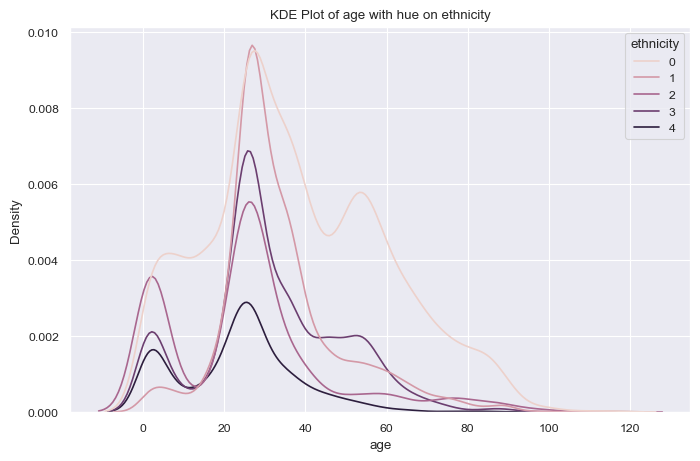

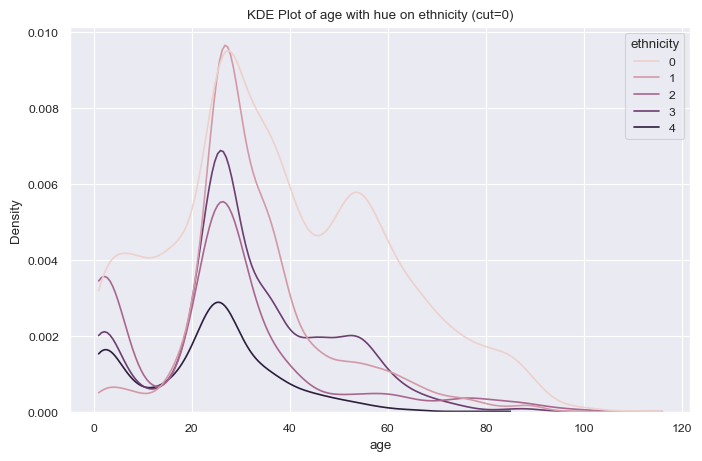

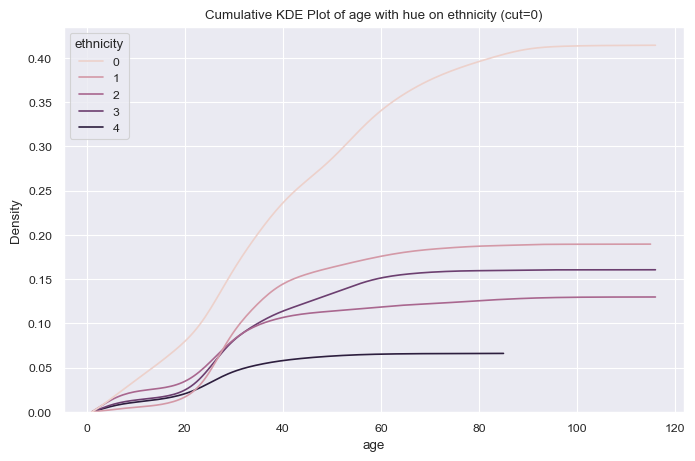

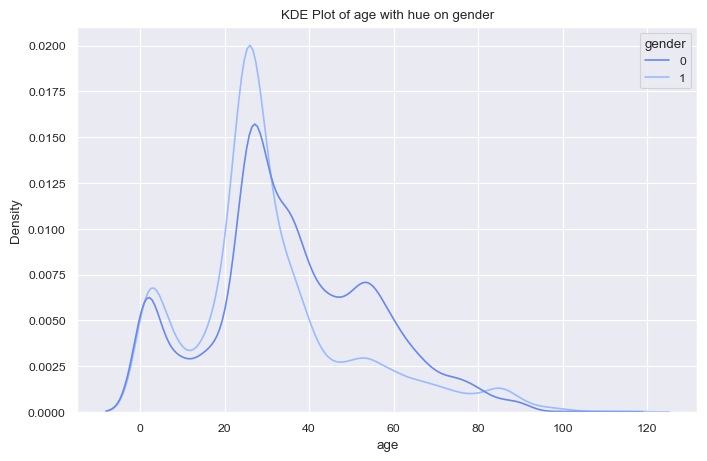

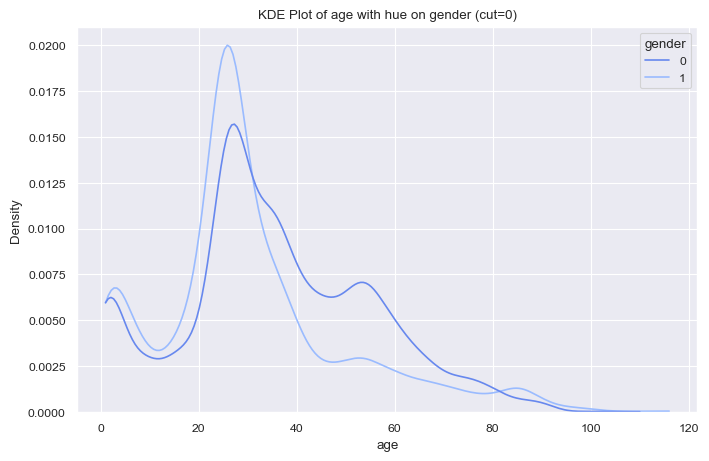

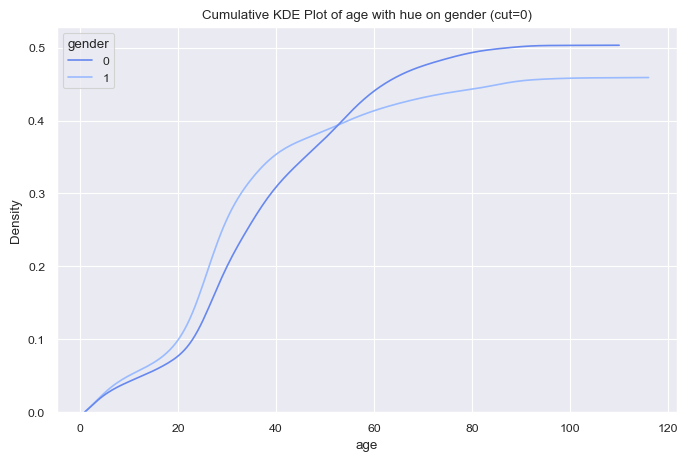

In [20]:
visualizer = DataVisualizer(age_gender_data, plot_width=8, plot_height=5)
#visualizer.visualize_all(num_vars=['age','ethnicity'], cat_vars=['ethnicity','gender'], hue=['ethnicity','gender'])
#visualizer.visualize_all(num_vars=['age','ethnicity'], cat_vars=['gender'], hue=['ethnicity','gender'])
visualizer.visualize_kdeplots(num_vars=['age'], hue=['ethnicity','gender'])

## 4- We print some pictures from our dataset to understand its content. <a id="section4"></a>

* [Go back to index](#index)

#### 4.0. We first apply the necessary transformations to convert the 'pixels' variable (with object type) to an array and later to a tensor

```python
return tf.reshape(np.array(pixels.split(), dtype="float32"), (48, 48,1))
```

This line of code is taking a string of pixel values, splitting it into a list, converting that list into a numpy array of type float32, and then reshaping that array into a 3D tensor with a shape of (48, 48,1)

In [21]:
# Define a function to convert pixel strings to tensors
def convert_pixels_to_tensor(pixels):
    return tf.reshape(np.array(pixels.split(), dtype="float32"), (48, 48,1))

# Copy the DataFrame and apply the conversion function
age_gender_data_tensor = age_gender_data.copy()
age_gender_data_tensor['pixels'] = age_gender_data['pixels'].apply(convert_pixels_to_tensor)

In [22]:
# Print the type of the entire 'pixels' column
print(f'{Back.RED}age_gender_data_tensor["pixels"] type:{Back.RESET}',
      f"\n{Back.BLUE}{type(age_gender_data_tensor['pixels'])}{Back.RESET}")

# Print the type of the first item in the 'pixels' column
print(f'{Back.RED}Type of the first item in age_gender_data_tensor["pixels"]:{Back.RESET}',
      f"\n{Back.BLUE}{type(age_gender_data_tensor['pixels'].iloc[0])}{Back.RESET}")


age_gender_data_tensor["pixels"] type: 
<class 'pandas.core.series.Series'>
Type of the first item in age_gender_data_tensor["pixels"]: 
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [23]:
#print(f'{Back.RED}First item in age_gender_data["pixels"]:{Back.RESET}', f"\n{Back.BLUE}{age_gender_data['pixels'].iloc[0]}{Back.RESET}")
#print(f'{Back.RED}First item in age_gender_data_tensor["pixels"]:{Back.RESET}', f"\n{Back.BLUE}{age_gender_data_tensor['pixels'].iloc[0]}{Back.RESET}")

#### 4.1. display_filtered_images(age_gender_data, age=1, ethnicity=0, gender=0, num_images=8)

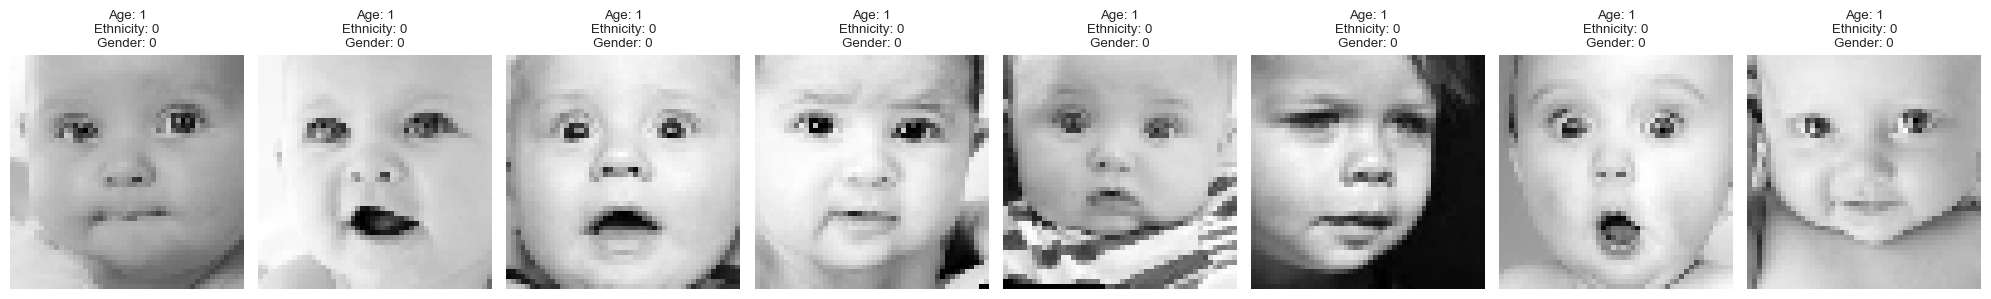

In [24]:
display_filtered_images(age_gender_data_tensor, age=1, ethnicity=0, gender=0, num_images=8)

#### 4.2. display_filtered_images(age_gender_data, age=10, ethnicity=1, gender=1, num_images=8)

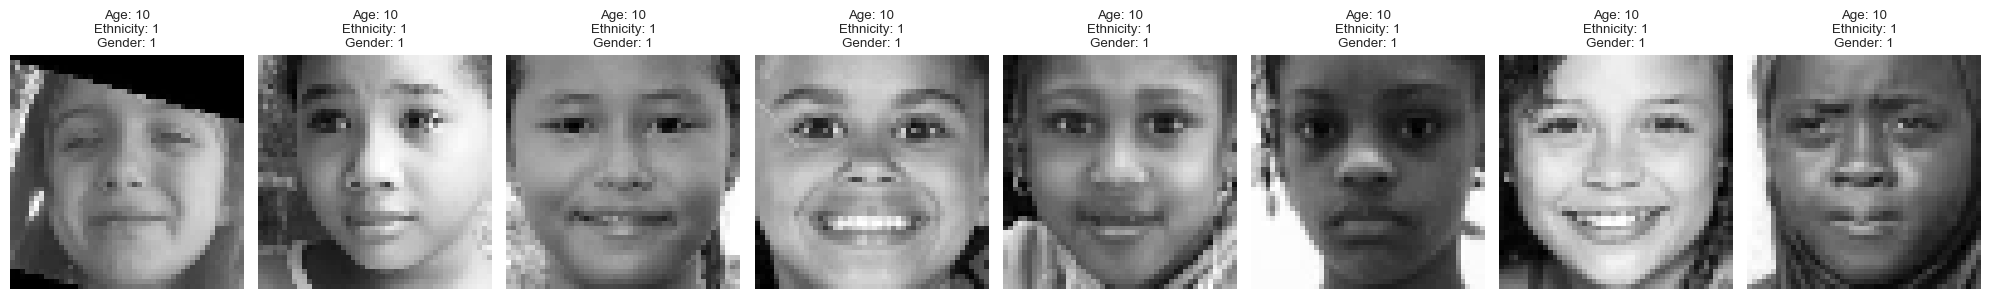

In [25]:
display_filtered_images(age_gender_data_tensor, age=10, ethnicity=1, gender=1, num_images=8)

#### 4.3. display_filtered_images(age_gender_data, age=20, ethnicity=2, gender=0, num_images=8)

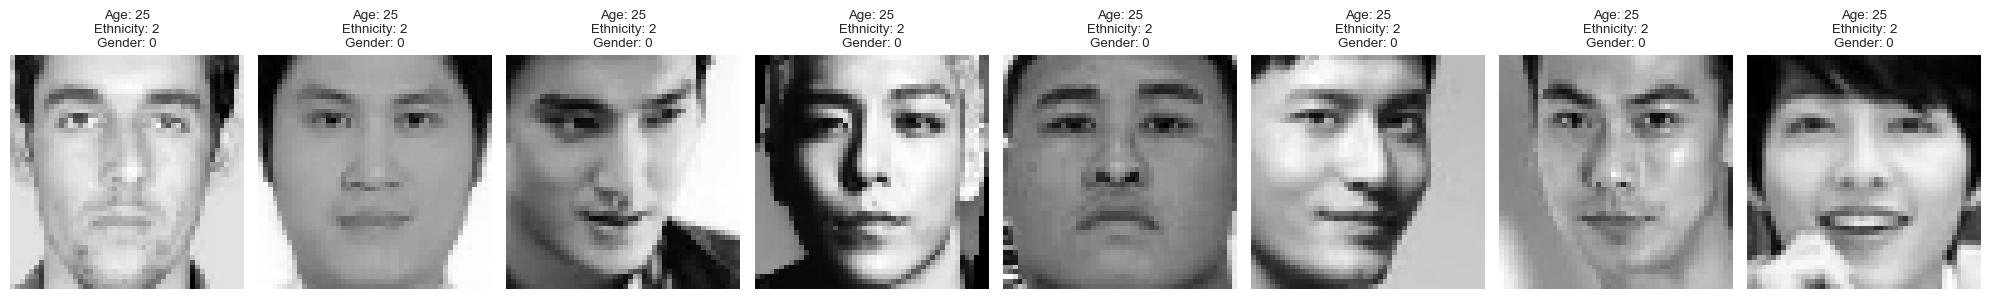

In [26]:
display_filtered_images(age_gender_data_tensor, age=25, ethnicity=2, gender=0, num_images=8)

#### 4.4. display_filtered_images(age_gender_data, age=35, ethnicity=3, gender=1, num_images=8)

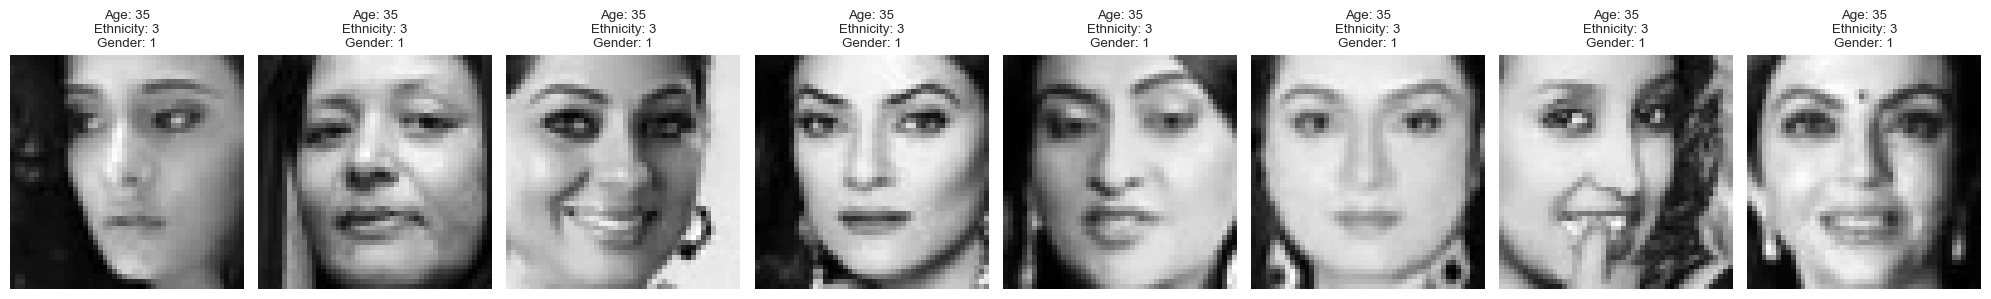

In [27]:
display_filtered_images(age_gender_data_tensor, age=35, ethnicity=3, gender=1, num_images=8)

#### 4.5. display_filtered_images(age_gender_data, age=45, ethnicity=4, gender=0, num_images=8)

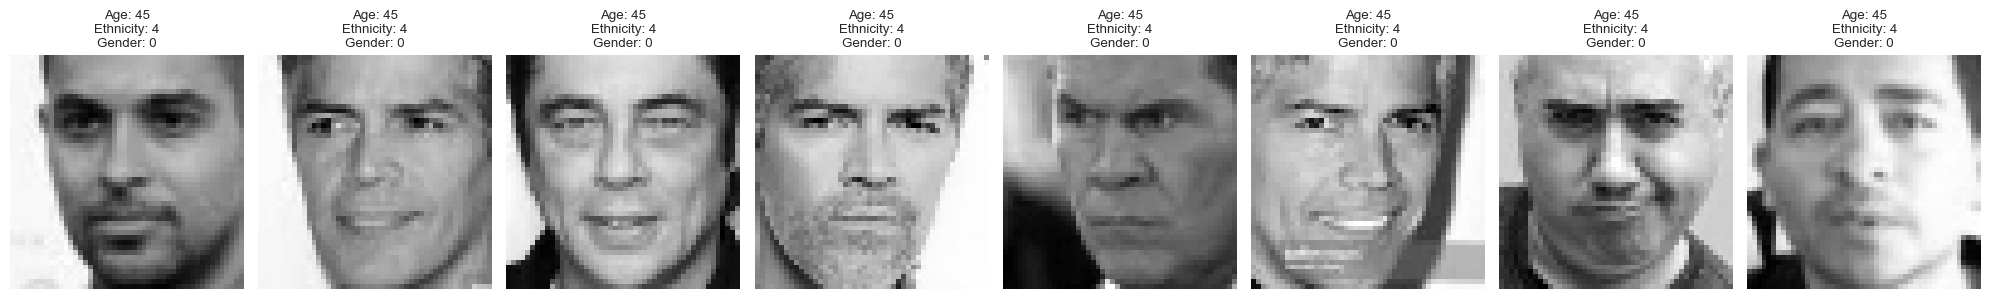

In [28]:
display_filtered_images(age_gender_data_tensor, age=45, ethnicity=4, gender=0, num_images=8)

#### 4.6. display_filtered_images(age_gender_data, age=55, ethnicity=0, gender=1, num_images=8)

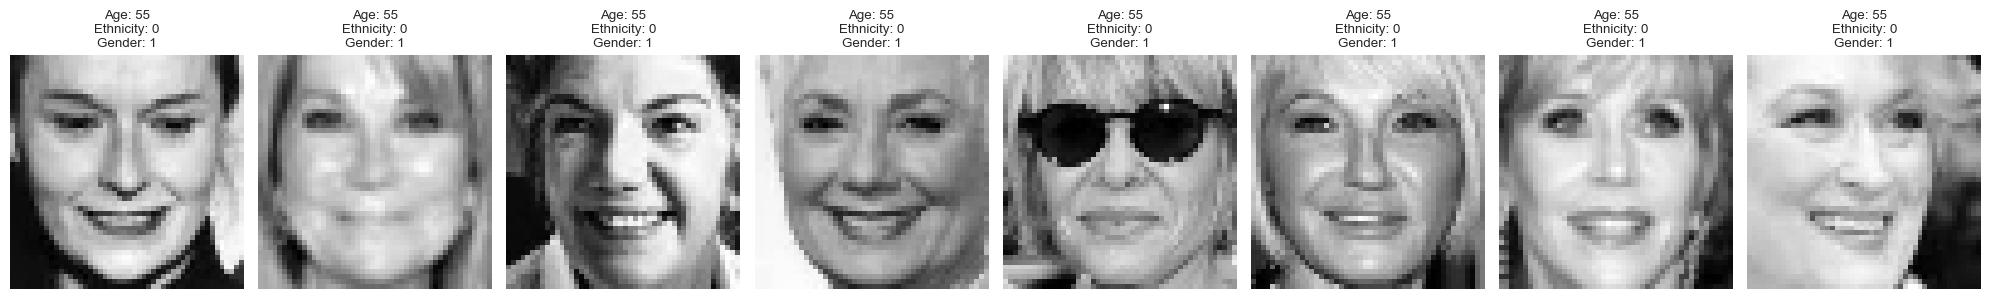

In [29]:
display_filtered_images(age_gender_data_tensor, age=55, ethnicity=0, gender=1, num_images=8)

#### 4.7. display_filtered_images(age_gender_data, age=65, ethnicity=1, gender=0, num_images=8)

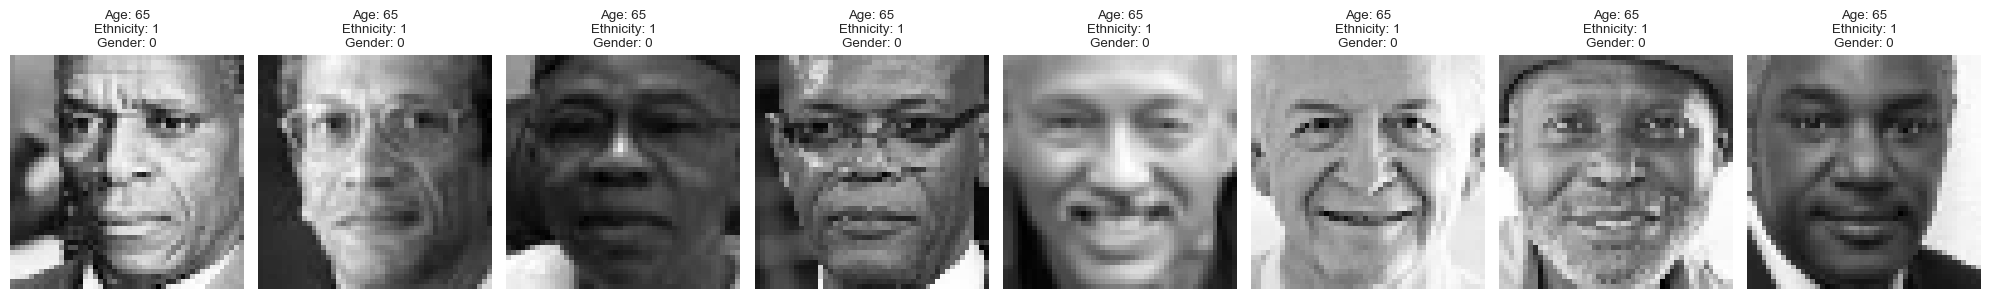

In [30]:
display_filtered_images(age_gender_data_tensor, age=65, ethnicity=1, gender=0, num_images=8)

#### 4.8. display_filtered_images(age_gender_data, age=40, ethnicity=2, gender=1, num_images=8)

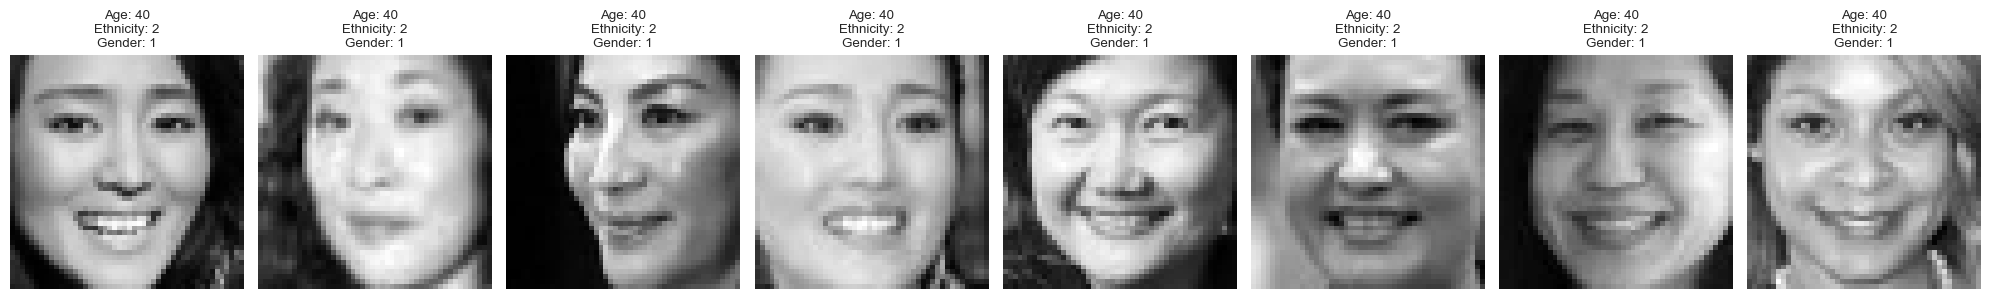

In [31]:
display_filtered_images(age_gender_data_tensor, age=40, ethnicity=2, gender=1, num_images=8)

#### 4.9. display_filtered_images(age_gender_data, age=5, ethnicity=4, gender=1, num_images=8)

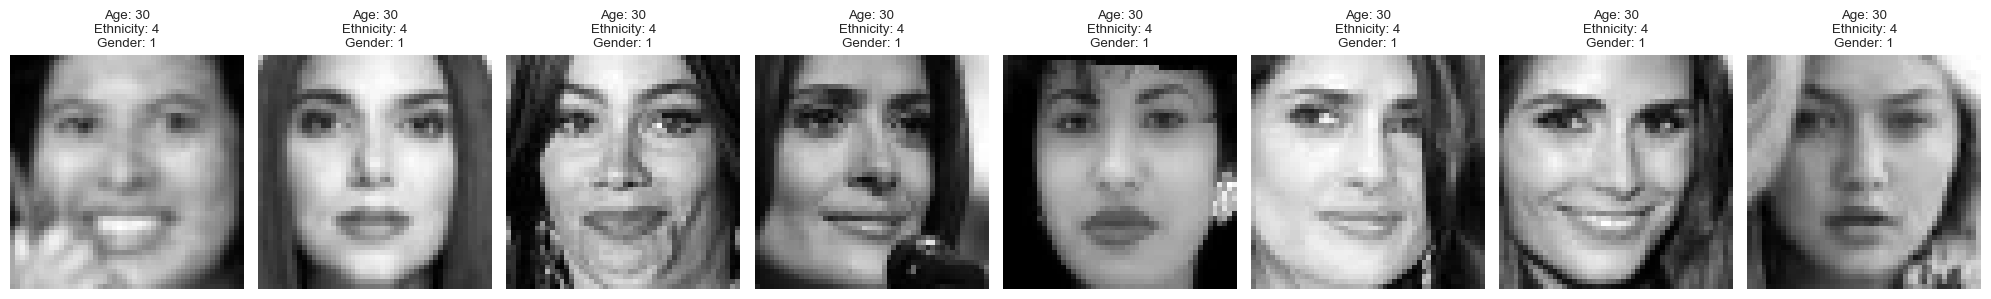

In [32]:
display_filtered_images(age_gender_data_tensor, age=30, ethnicity=4, gender=1, num_images=8)

## 5. Preparing the data for later usage in a neural network. <a id="section5"></a>

* [Go back to index](#index)

We have a class to carry out the data preprocessing for our neural network. It has the following built-in functions:

1. init

- 1.1. The function returns the training and validation indices. These indices can then be used to create training and validation datasets from the original DataFrame. The advantage of this approach is that it allows for stratified sampling, ensuring that the training and validation sets have the same class distribution as the original dataset.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

2. calculate_stats

- 2.1. This Python code defines a method calculate_stats that calculates the mean and standard deviation of pixel values from a list of pixel strings. It converts each pixel string into a tensor, normalizes the tensor by dividing by 255, and then updates the sum of pixel values, sum of squared pixel values, and total number of pixels. After processing all pixel strings, it calculates and returns the mean and standard deviation.

3. create_dataset

- 3.1. `tf.data.Dataset.from_tensor_slices` function is a convenient way to create a Dataset from data in memory. It creates a dataset where each element is a slice of the input tensors.

https://www.tensorflow.org/api_docs/python/tf/data/Dataset
https://www.tensorflow.org/api_docs/python/tf/numpy_function

- 3.2. `map` function is used to apply a function to each element in the dataset

https://docs.python.org/3/library/functions.html#map

- 3.3. `tf.numpy_function` is a TensorFlow operation that wraps a Python function. the Python function being wrapped is `self.preprocess`, and it's being passed two input tensors: `x` and `y`. `x` and `y` are the pixel data and label for an image, respectively. The dtype of the output tensors are specified as ``tf.float32` and `tf.int64`, which means the preprocess function is expected to return a tuple containing a float32 tensor and an int64 tensor.

- 3.4. The `num_parallel_calls` argument in the map function is set to `tf.data.experimental.AUTOTUNE`, which means that TensorFlow will choose the number of parallel calls to use based on available CPU.

https://www.tensorflow.org/api_docs/python/tf/data/experimental

4. preprocess

- 4.1. The `np.fromstring` function is used to convert a string of pixel values into a numpy array. The `pixel_string.decode('utf-8')` part of the code is decoding a byte string of pixel values into a regular string. The `sep=' '` argument specifies that the pixel values in the string are separated by spaces. The `dtype=np.float32` argument specifies that the data type of the numpy array should be float32.

https://numpy.org/doc/stable/reference/generated/numpy.fromstring.html
https://numpy.org/doc/stable/reference/arrays.scalars.html#numpy.float16
https://numpy.org/doc/stable/reference/generated/numpy.reshape.html#numpy-reshape


In [33]:
class DataProcessor:
    def __init__(self, dataframe, label_column, test_size=0.3, random_state=42):
        """
        Initialize the DataProcessor class with a dataframe, the name of the label column,
        split it into training and validation indices, and calculate the mean and standard
        deviation for normalization.

        Args:
            dataframe (pd.DataFrame): The full DataFrame.
            label_column (str): The name of the column to be used as the label.
            test_size (float): The proportion of the dataset to include in the test split.
            random_state (int): The seed used by the random number generator.
        """
        self.dataframe = dataframe
        self.label_column = label_column
        self.indices = np.arange(len(dataframe))
        self.train_indices, self.val_indices, _, _ = train_test_split(
            self.indices, dataframe[label_column].values, test_size=test_size, random_state=random_state)
        
        self.mean, self.std = self.calculate_stats(dataframe['pixels'])

    def calculate_stats(self, pixels_column):
        """Calculate the mean and standard deviation of a column of pixels.
        Args:
            pixels_column (list): A list of strings representing pixel values.
        Returns:
            tuple: A tuple containing the mean and standard deviation of the pixel values.
        """
        sum_pixels = tf.constant(0.0)
        sum_squared_pixels = tf.constant(0.0)
        num_pixels = 0

        for pixel_string in pixels_column:
            tensor = tf.convert_to_tensor([float(pix) for pix in pixel_string.split()], dtype=tf.float32)
            normalized_tensor = tensor / 255.0
            sum_pixels += tf.reduce_sum(normalized_tensor)
            sum_squared_pixels += tf.reduce_sum(tf.square(normalized_tensor))
            num_pixels += tf.size(normalized_tensor).numpy()

        mean = sum_pixels / num_pixels
        std = tf.sqrt((sum_squared_pixels / num_pixels) - tf.square(mean))
        return mean.numpy(), std.numpy()

    def create_dataset(self, dataframe, batch_size=32, shuffle=True):
        """
        Create a TensorFlow dataset from a pandas dataframe.

        Args:
            dataframe (pd.DataFrame): DataFrame containing the data.
            batch_size (int): Batch size.
            shuffle (bool): Whether to shuffle the data.

        Returns:
            tf.data.Dataset: A TensorFlow dataset.
        """
        def preprocess(pixel_string, label):
            """
            Preprocess the pixel string and label.

            Args:
                pixel_string (str): The pixel string.
                label: The label.

            Returns:
                tuple: A tuple containing the preprocessed pixels and label.
            """
            def _preprocess(pixel_string, label):
                """
                Preprocess the pixel string and label.

                Args:
                    pixel_string (str): The pixel string.
                    label: The label.

                Returns:
                    tuple: A tuple containing the preprocessed pixels and label.
                """
                pixels = np.fromstring(pixel_string.decode('utf-8'), sep=' ', dtype=np.float32)
                pixels = pixels.reshape(48, 48, 1)
                pixels = (pixels - self.mean) / self.std
                return pixels, label

            pixels, label = tf.numpy_function(_preprocess, [pixel_string, label], [tf.float32, tf.int64])
            pixels.set_shape((48, 48, 1))
            label.set_shape(())
            return pixels, label

        pixel_strings = dataframe['pixels'].values
        labels = dataframe[self.label_column].values  # Use the label column name passed to the class
        dataset = tf.data.Dataset.from_tensor_slices((pixel_strings, labels))
        dataset = dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(dataframe))
        return dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    def create_subset_dataset(self, indices, batch_size=32, shuffle=True):
        """
        Creates a subset dataset based on the given indices.

        Parameters:
        - indices (list): List of indices to select from the original dataset.
        - batch_size (int): Number of samples per batch. Default is 32.
        - shuffle (bool): Whether to shuffle the dataset. Default is True.

        Returns:
        - subset_dataset (Dataset): Subset dataset containing the selected samples.
        """
        subset_dataframe = self.dataframe.iloc[indices]
        return self.create_dataset(subset_dataframe, batch_size=batch_size, shuffle=shuffle)

#### 5.1. We instantiate the class and create the train and test datasets. We shuffle the training dataset but we don´t the testing dataset. We select the 'gender' as the target/label for the model.

In [34]:
# Initialize the DataProcessor instance
data_processor = DataProcessor(age_gender_data, 'gender')

# Create the training dataset using the DataProcessor instance
train_dataset_1= data_processor.create_subset_dataset(data_processor.train_indices, batch_size=32, shuffle=True)

# Create the validation dataset using the DataProcessor instance
val_dataset_1 = data_processor.create_subset_dataset(data_processor.val_indices, batch_size=32, shuffle=False)


#### 5.2. We inspect our training and validation datasets to understand their structure and element shapes of a Tensorflow `Dataset` object.

In [35]:
# Example function to inspect dataset structure and element shapes
def inspect_dataset(dataset):
    # Take one batch from the dataset
    for inputs, labels in dataset.take(1):
        # Print the shape of the inputs and labels
        print(f'{Back.RED}Input shape:{Back.RESET}', f"{Back.BLUE}{inputs.shape}{Back.RESET}")
        print(f'{Back.RED}Label shape:{Back.RESET}', f"{Back.BLUE}{labels.shape}{Back.RESET}")
        # Optionally, check the dtype
        print(f'{Back.RED}Input dtype:{Back.RESET}', f"{Back.BLUE}{inputs.dtype}{Back.RESET}")
        print(f'{Back.RED}Label dtype:{Back.RESET}', f"{Back.BLUE}{labels.dtype}{Back.RESET}")

# Assuming train_dataset and val_dataset are your datasets
print(f'{Back.RED}Training Dataset:{Back.RESET}')
inspect_dataset(train_dataset_1)
print(f'{Back.RED}Type:{Back.RESET}', f"{Back.BLUE}{type(train_dataset_1)}{Back.RESET}")
print(f'{Back.RED}Validation Dataset:{Back.RESET}')
inspect_dataset(val_dataset_1)
print(f'{Back.RED}Type:{Back.RESET}', f"{Back.BLUE}{type(val_dataset_1)}{Back.RESET}")

Training Dataset:
Input shape: (32, 48, 48, 1)
Label shape: (32,)
Input dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int64'>
Type: <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Validation Dataset:
Input shape: (32, 48, 48, 1)
Label shape: (32,)
Input dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int64'>
Type: <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


#### 5.3. We plot some pictures to ensure we are going in the right direction.

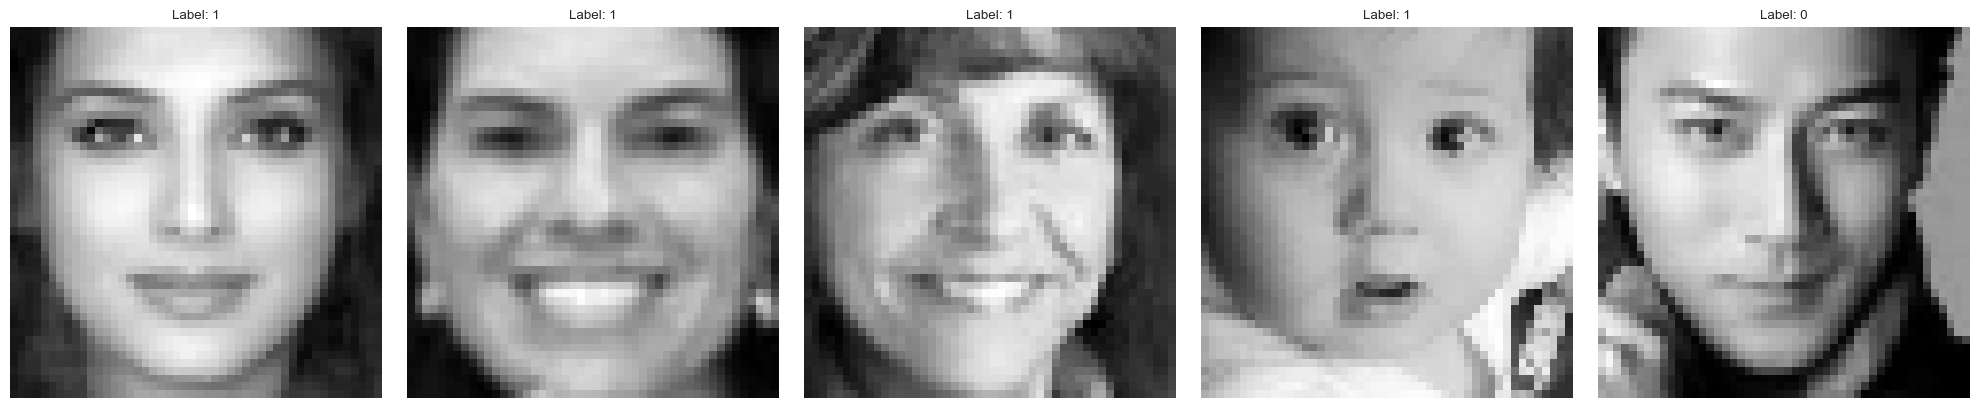

In [36]:
# Adjust 'num_images' to display the desired number of images
num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(20, 4))

for i, (images, labels) in enumerate(train_dataset_1.take(num_images)):
    img_array = images[0].numpy().squeeze()  # Select the first image in the batch and remove singleton dimensions
    ax = axes[i]
    ax.imshow(img_array, cmap='gray')  # Display the image in grayscale
    title = f"Label: {labels[0].numpy()}"  # Display the label for the first image
    ax.set_title(title)  # Set the title with label information
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()


## 6. We train our first model: a single layer perceptron. Model 1 <a id="section6"></a>

* [Go back to index](#index)


```python
model = models.Sequential
([
    layers.Flatten(input_shape=(48, 48, 1)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
```

https://keras.io/guides/sequential_model/

The `models.Sequential` function is a constructor for a Sequential model. The Sequential model is a linear stack of layers, where you can just add one layer at a time in a sequential manner.

https://keras.io/api/layers/reshaping_layers/flatten/

The `Flatten` layer is used to flatten the input. It does this by converting a multi-dimensional tensor into a one-dimensional tensor (also known as a vector).

https://keras.io/api/layers/core_layers/dense/

The `Dense` layer performs a dot product between the input and a set of learned weights, and then adds a bias term to the result. It's called a `Dense` layer because every neuron in a `Dense` layer is connected to every neuron in the previous layer. The `Dense` layer takes two arguments:
- The first argument, 64, is the number of neurons (also known as nodes) in the layer. The number of neurons is a hyperparameter.
- The second argument, `activation='relu'`, specifies the activation function to use after performing the dot product and adding the bias.

https://keras.io/api/layers/activations/

The sigmoid function is often used in the output layer of a binary classification model because it squashes its input into the range [0, 1], which can be interpreted as a probability.



#### 6.1. We define the architecture of the first model. Model 1 <a id="section61"></a>

* [Go back to index](#index)


In [37]:
# Simplified model
model = models.Sequential([
    # Flatten the input layer
    layers.Flatten(input_shape=(48, 48, 1)),  # Assuming grayscale images
    # Single fully connected layer
    layers.Dense(64, activation='relu'),
    # Output layer with 1 unit for binary classification, using sigmoid for binary classification
    layers.Dense(1, activation='sigmoid')
])

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

The optimizer is responsible for updating the weights of the network in response to the error it makes on the training data. The goal of the optimizer is to minimize this error, and the way it does this is by adjusting the weights in the direction that makes the error smaller. This process is known as gradient descent.

The `tf.keras.optimizers.Adam` function is used to create an instance of the Adam optimizer. Adam is a popular choice of optimizer because it combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp.

In [38]:
# Using Adam as a more adaptive optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

https://keras.io/api/losses/probabilistic_losses/#binary_crossentropy-function

The loss function is a measure of how well the model's predictions match the true values. During training, the goal of the optimizer is to minimize the value of the loss function.

The `tf.keras.losses.BinaryCrossentropy` function is used to create an instance of the Binary Cross-Entropy loss. Binary Cross-Entropy loss is used in binary classification tasks, where each input can belong to one of two classes. It measures the "distance" between the model's predictions and the true values.

In [39]:
loss_function = tf.keras.losses.BinaryCrossentropy()

https://keras.io/api/metrics/classification_metrics/#f1score-class

The `tf.keras.metrics.BinaryAccuracy` function is used to create an instance of the Binary Accuracy metric.

The threshold parameter is set to 0.5. This means that the model's predicted probabilities that the inputs belong to the positive class will be rounded to the nearest integer to obtain the predicted classes. If the predicted probability is greater than or equal to 0.5, the predicted class is 1 (the positive class); otherwise, the predicted class is 0 (the negative class).

In [40]:
metric = tf.keras.metrics.BinaryAccuracy(threshold=0.5)

https://keras.io/api/models/model_training_apis/

https://keras.io/api/losses/

https://keras.io/api/metrics/

The `model.compile` method is used to configure the learning process before training the model. It takes three main arguments: an optimizer, a loss function, and a list of metrics.

In [41]:
# Compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metric)

#### 6.2. We dig deeper into the model features. Model 1 <a id="section62"></a>

* [Go back to index](#index)

In [42]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 64)                147520    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 147,585
Trainable params: 147,585
Non-trainable params: 0
_________________________________________________________________


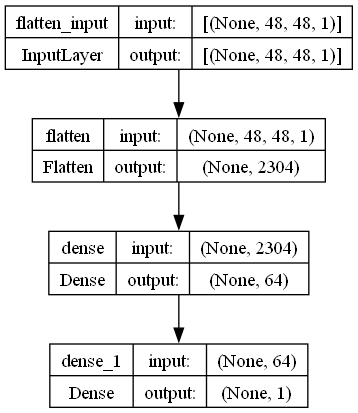

In [43]:
# Visualize the model
plot_model(model, show_shapes=True, show_layer_names=True, rankdir='TB')

#### 6.3. We train our model. Model 1 <a id="section63"></a>

* [Go back to index](#index)

In [44]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [45]:
class LearningRateLogger(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.learning_rates = []
        
    def on_epoch_end(self, epoch, logs=None):
        self.learning_rates.append(self.model.optimizer.lr.numpy())

# Include this callback during training
lr_logger = LearningRateLogger()


In [46]:
start_time = time.time()
history = model.fit(train_dataset_1,
                    epochs=1,
                    validation_data=val_dataset_1,
                    callbacks=[lr_logger, stop_early])
end_time = time.time()

519/519 [==============================] - 116s 74ms/step - loss: 42.2323 - binary_accuracy: 0.6876 - val_loss: 7.5238 - val_binary_accuracy: 0.8037


#### 6.4. Training time. Model 1 <a id="section64"></a>

* [Go back to index](#index)

In [47]:
# Calculate and print the duration
duration_mins = (end_time - start_time)/60
print(f'{Back.RED}Training completed in (mins):{Back.RESET}',
    f"\n{Back.BLUE}{duration_mins:.3f}{Back.RESET}")

Training completed in (mins): 
1.939


#### 6.5. Model evaluation. Model 1 <a id="section65"></a>

* [Go back to index](#index)

##### 1. Confusion Matrix

  1/223 [..............................] - ETA: 51s

223/223 [==============================] - 36s 162ms/step
              precision    recall  f1-score   support

     Class 0       0.85      0.76      0.80      3741
     Class 1       0.76      0.85      0.80      3371

    accuracy                           0.80      7112
   macro avg       0.81      0.81      0.80      7112
weighted avg       0.81      0.80      0.80      7112

Accuracy: 80.37%


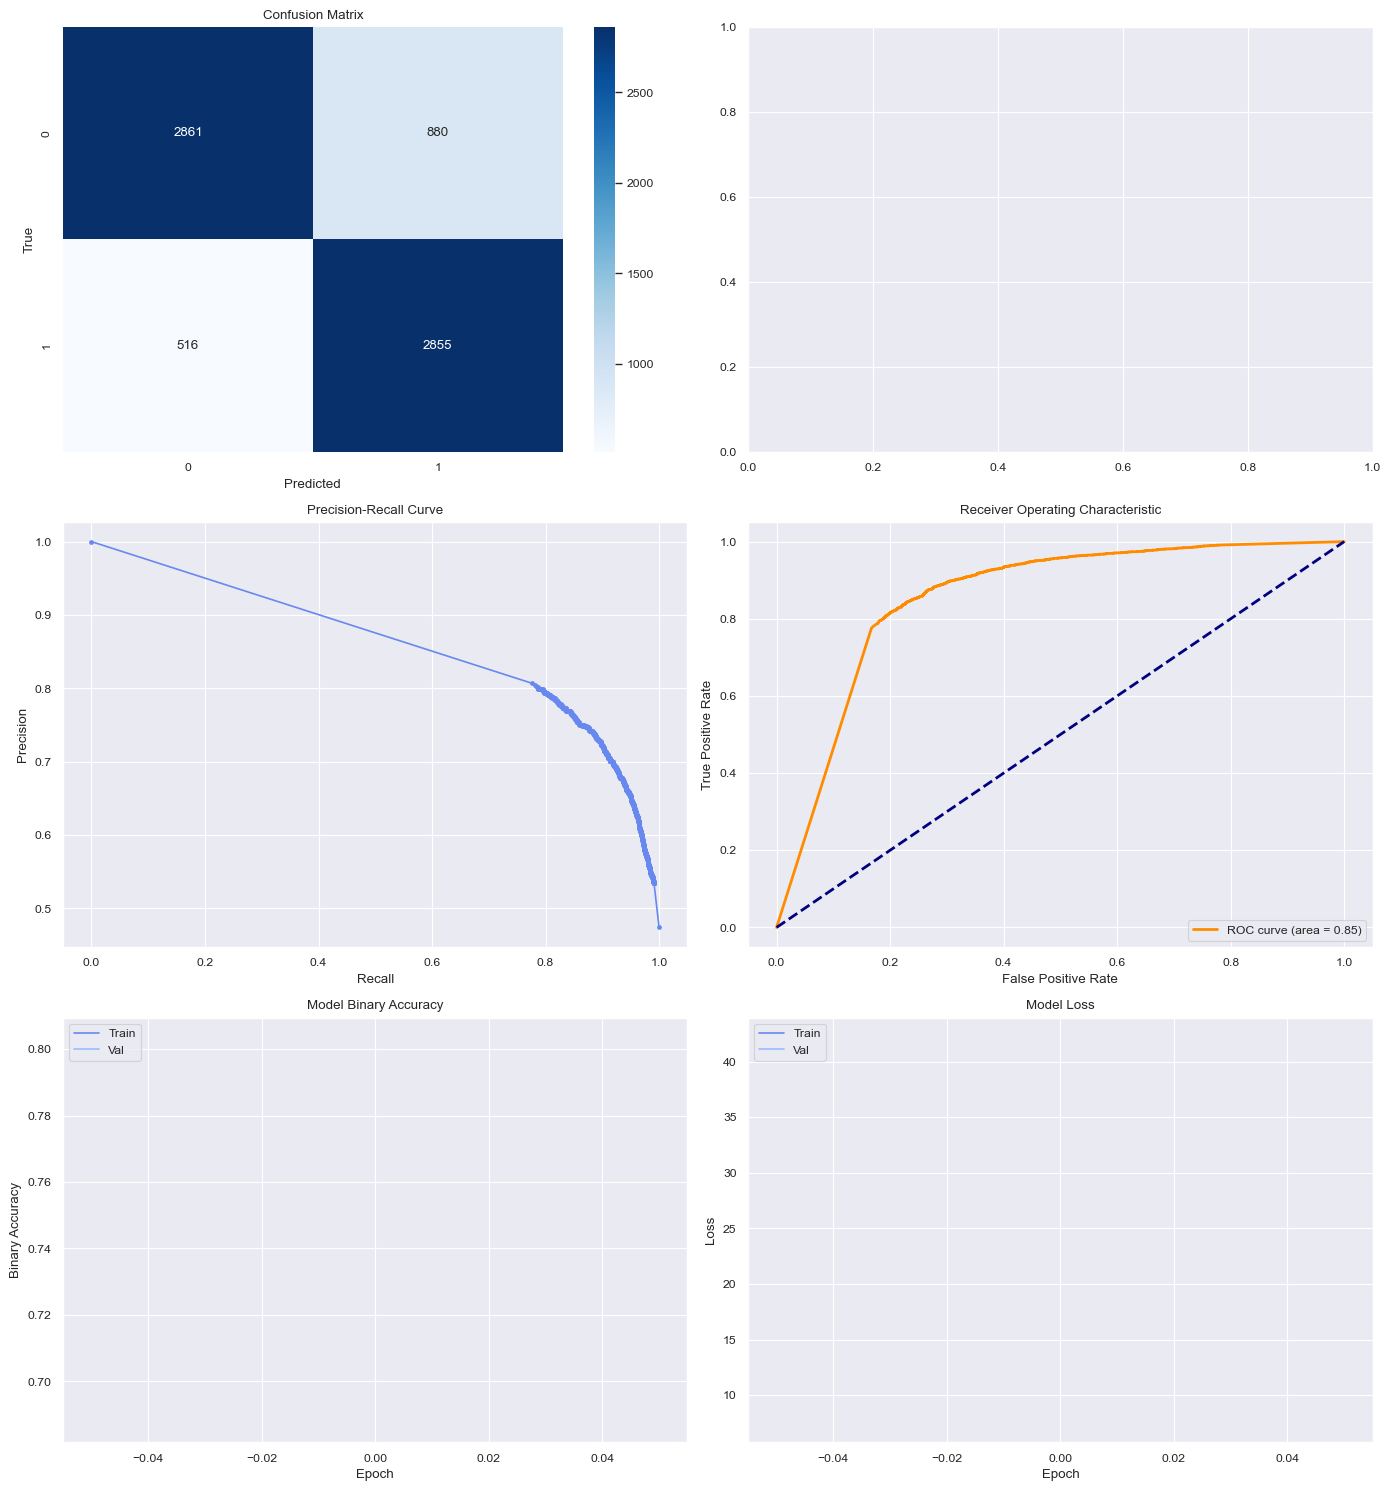

In [48]:
evaluate_neural_network(model, val_dataset_1, history)

223/223 [==============================] - 33s 148ms/step


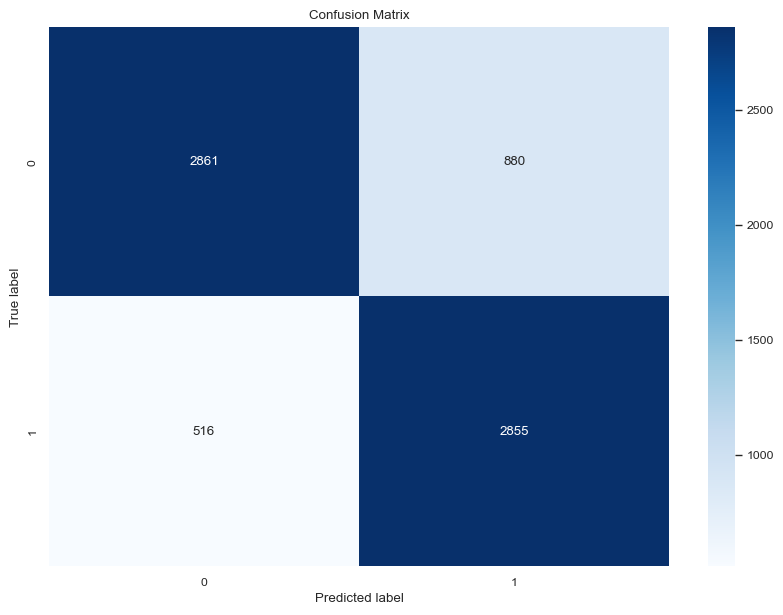

              precision    recall  f1-score   support

     Class 0       0.85      0.76      0.80      3741
     Class 1       0.76      0.85      0.80      3371

    accuracy                           0.80      7112
   macro avg       0.81      0.81      0.80      7112
weighted avg       0.81      0.80      0.80      7112

Accuracy: 80.37%


In [49]:

# Predict the labels for the validation set
y_pred_probs = model.predict(val_dataset_1)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

#y_pred = (y_pred_probs > 0.5).astype(int)  # Threshold probabilities to get binary class labels

# Extract true labels from the validation dataset
y_true = np.concatenate([np.array([y.numpy()]) for x, y in val_dataset_1.unbatch()], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print the classification report for all metrics
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

# Calculate and print the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


#### 6.6. Visual inspection of missclassified pictures. Model 1 <a id="section66"></a>

* [Go back to index](#index)

In [50]:
# Threshold probabilities to get binary class labels
#y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)
misclassified_indices = np.where(y_pred != y_true)[0]

In [51]:
def display_misclassified_images(dataset, misclassified_indices, num_images=10):
    """
    Display misclassified images from the dataset.

    Args:
        dataset (tf.data.Dataset): The dataset containing images and labels.
        misclassified_indices (np.array): Array containing indices of misclassified images.
        num_images (int): Number of misclassified images to display.
    """
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    i = 0  # Index for subplot
    count = 0  # Count to keep track of how many images we have displayed
    
    for idx, (image, label) in enumerate(dataset.unbatch()):
        if idx in misclassified_indices and count < num_images:
            img = image.numpy().squeeze()
            ax = axes[i]
            ax.imshow(img, cmap='gray')
            ax.set_title(f"True: {label.numpy()}, Pred: {y_pred[idx]}")
            ax.axis('off')
            i += 1
            count += 1
        
        if count >= num_images:
            break

    plt.tight_layout()
    plt.show()


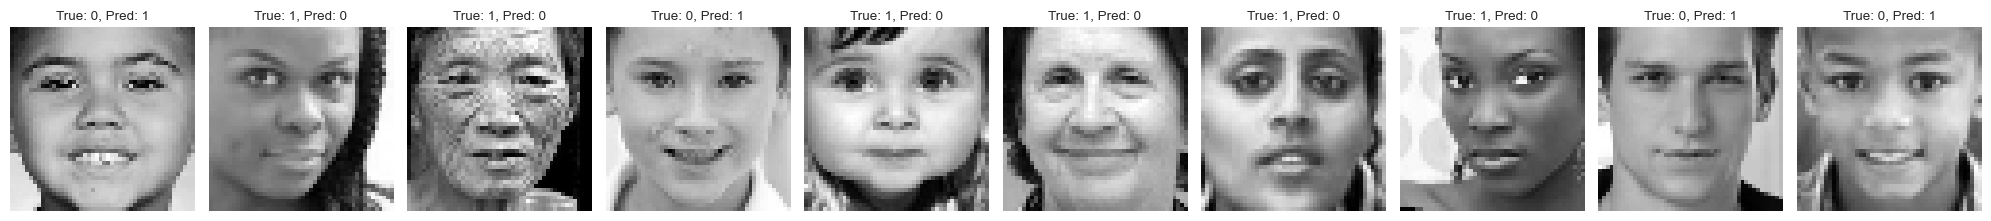

In [52]:
# Now call the function to display the misclassified images
display_misclassified_images(val_dataset_1, misclassified_indices)

In [53]:
# Example usage:
calculate_combined_misclassification_info(
    y_true, 
    y_pred, 
    age_gender_data, 
    category_names=['age', 'ethnicity', 'gender']
)


age - Misclassification rates:
  0-4: Total = 1605, Misclassified = 261 (16.26%)
  10-14: Total = 589, Misclassified = 132 (22.41%)
  100-104: Total = 14, Misclassified = 0 (0.00%)
  105-109: Total = 5, Misclassified = 0 (0.00%)
  110-114: Total = 6, Misclassified = 0 (0.00%)
  115-119: Total = 7, Misclassified = 5 (71.43%)
  15-19: Total = 942, Misclassified = 193 (20.49%)
  20-24: Total = 2310, Misclassified = 467 (20.22%)
  25-29: Total = 1634, Misclassified = 338 (20.69%)

age - Misclassification distribution:
  0-4: Misclassified = 261 (18.70%) of Total Misclassified = 1396
  10-14: Misclassified = 132 (9.46%) of Total Misclassified = 1396
  100-104: Misclassified = 0 (0.00%) of Total Misclassified = 1396
  105-109: Misclassified = 0 (0.00%) of Total Misclassified = 1396
  110-114: Misclassified = 0 (0.00%) of Total Misclassified = 1396
  115-119: Misclassified = 5 (0.36%) of Total Misclassified = 1396
  15-19: Misclassified = 193 (13.83%) of Total Misclassified = 1396
  20-24: M

#### 6.7. We train our model. Model 1.2. <a id="section67"></a>

* [Go back to index](#index)

We are changing our batch size from 32 to 64 instances

In [54]:
# Initialize the DataProcessor instance
data_processor = DataProcessor(age_gender_data, 'gender')

# Create the training dataset using the DataProcessor instance
train_dataset_2= data_processor.create_subset_dataset(data_processor.train_indices, batch_size=64, shuffle=True)

# Create the validation dataset using the DataProcessor instance
val_dataset_2 = data_processor.create_subset_dataset(data_processor.val_indices, batch_size=64, shuffle=False)

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

The selected code is creating an instance of the EarlyStopping callback from TensorFlow's Keras API. Callbacks in Keras are functions that can be applied at certain stages of the training process, such as at the end of each epoch. They are useful for logging, model checkpointing, learning rate changing, and much more.

In the provided code, the ``EarlyStopping`` callback is configured to monitor the ``val_loss`` metric. The val_loss is the value of the loss function for your cross-validation data, i.e., the error rate on data not used in training.

The ``min_delta`` parameter is the minimum change in the monitored quantity to qualify as an improvement. In this case, it's set to 0, meaning any improvement, no matter how small, counts as an improvement.

The ``patience`` parameter is the number of epochs with no improvement after which training will be stopped. Here, it's set to 5, meaning that the training process will stop if there has been no improvement in the val_loss for 5 consecutive epochs.

In [55]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", min_delta=0, patience=5)

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

The selected code is creating an instance of the ``ModelCheckpoint`` callback from TensorFlow's Keras API. Callbacks in Keras are functions that can be applied at certain stages of the training process, such as at the end of each epoch. They are useful for logging, model checkpointing, learning rate changing, and much more.

The ``save_best_only`` parameter, when set to True, means that the latest best model according to the quantity monitored will not be overwritten. If it's False, all models will be saved. Here, it's set to True, so only the best model (in terms of val_loss) will be saved.

In [56]:
FILENAME_MODEL="Model_12_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
FILEPATH_MODEL12 = os.path.join(current_working_directory, 'ckpt', FILENAME_MODEL)


model12ckpt_callback = tf.keras.callbacks.ModelCheckpoint(monitor="val_binary_accuracy",
                                                        filepath=FILEPATH_MODEL12,
                                                        verbose=1,
                                                        save_weights_only=False,
                                                        save_best_only=True)


In [57]:
start_time = time.time()
history_v2 = model.fit(train_dataset_2,
                    epochs=20,
                    validation_data=val_dataset_2,
                    callbacks=[es_callback, model12ckpt_callback])
end_time = time.time()

Epoch 1/20


240/260 [==========================>...] - ETA: 0s - loss: 9.8499 - binary_accuracy: 0.7658 
Epoch 1: val_binary_accuracy improved from -inf to 0.80709, saving model to model12_checkpoint.h5
260/260 [==============================] - 113s 140ms/step - loss: 9.6239 - binary_accuracy: 0.7680 - val_loss: 6.1918 - val_binary_accuracy: 0.8071
Epoch 2/20
258/260 [============================>.] - ETA: 0s - loss: 9.8593 - binary_accuracy: 0.7595 
Epoch 2: val_binary_accuracy did not improve from 0.80709
260/260 [==============================] - 111s 132ms/step - loss: 9.8407 - binary_accuracy: 0.7597 - val_loss: 6.1517 - val_binary_accuracy: 0.8054
Epoch 3/20
239/260 [==========================>...] - ETA: 0s - loss: 7.0715 - binary_accuracy: 0.7795
Epoch 3: val_binary_accuracy did not improve from 0.80709
260/260 [==============================] - 111s 131ms/step - loss: 6.9095 - binary_accuracy: 0.7811 - val_loss: 4.6834 - val_binary_accuracy: 0.8022
Epoch 4/20
251/260 [===================

#### 6.4. Training time. Model 1.2 <a id="section68"></a>

* [Go back to index](#index)

In [59]:
# Calculate and print the duration
duration_mins = (end_time - start_time)/60
print(f'{Back.RED}Training completed in (mins):{Back.RESET}',
    f"\n{Back.BLUE}{duration_mins:.3f}{Back.RESET}")

Training completed in (mins): 
37.557


#### 6.5. Model evaluation. Model 1.2 <a id="section69"></a>

* [Go back to index](#index)

112/112 [==============================] - 32s 282ms/step
              precision    recall  f1-score   support

     Class 0       0.98      0.40      0.57      3741
     Class 1       0.60      0.99      0.75      3371

    accuracy                           0.68      7112
   macro avg       0.79      0.69      0.66      7112
weighted avg       0.80      0.68      0.65      7112

Accuracy: 67.96%


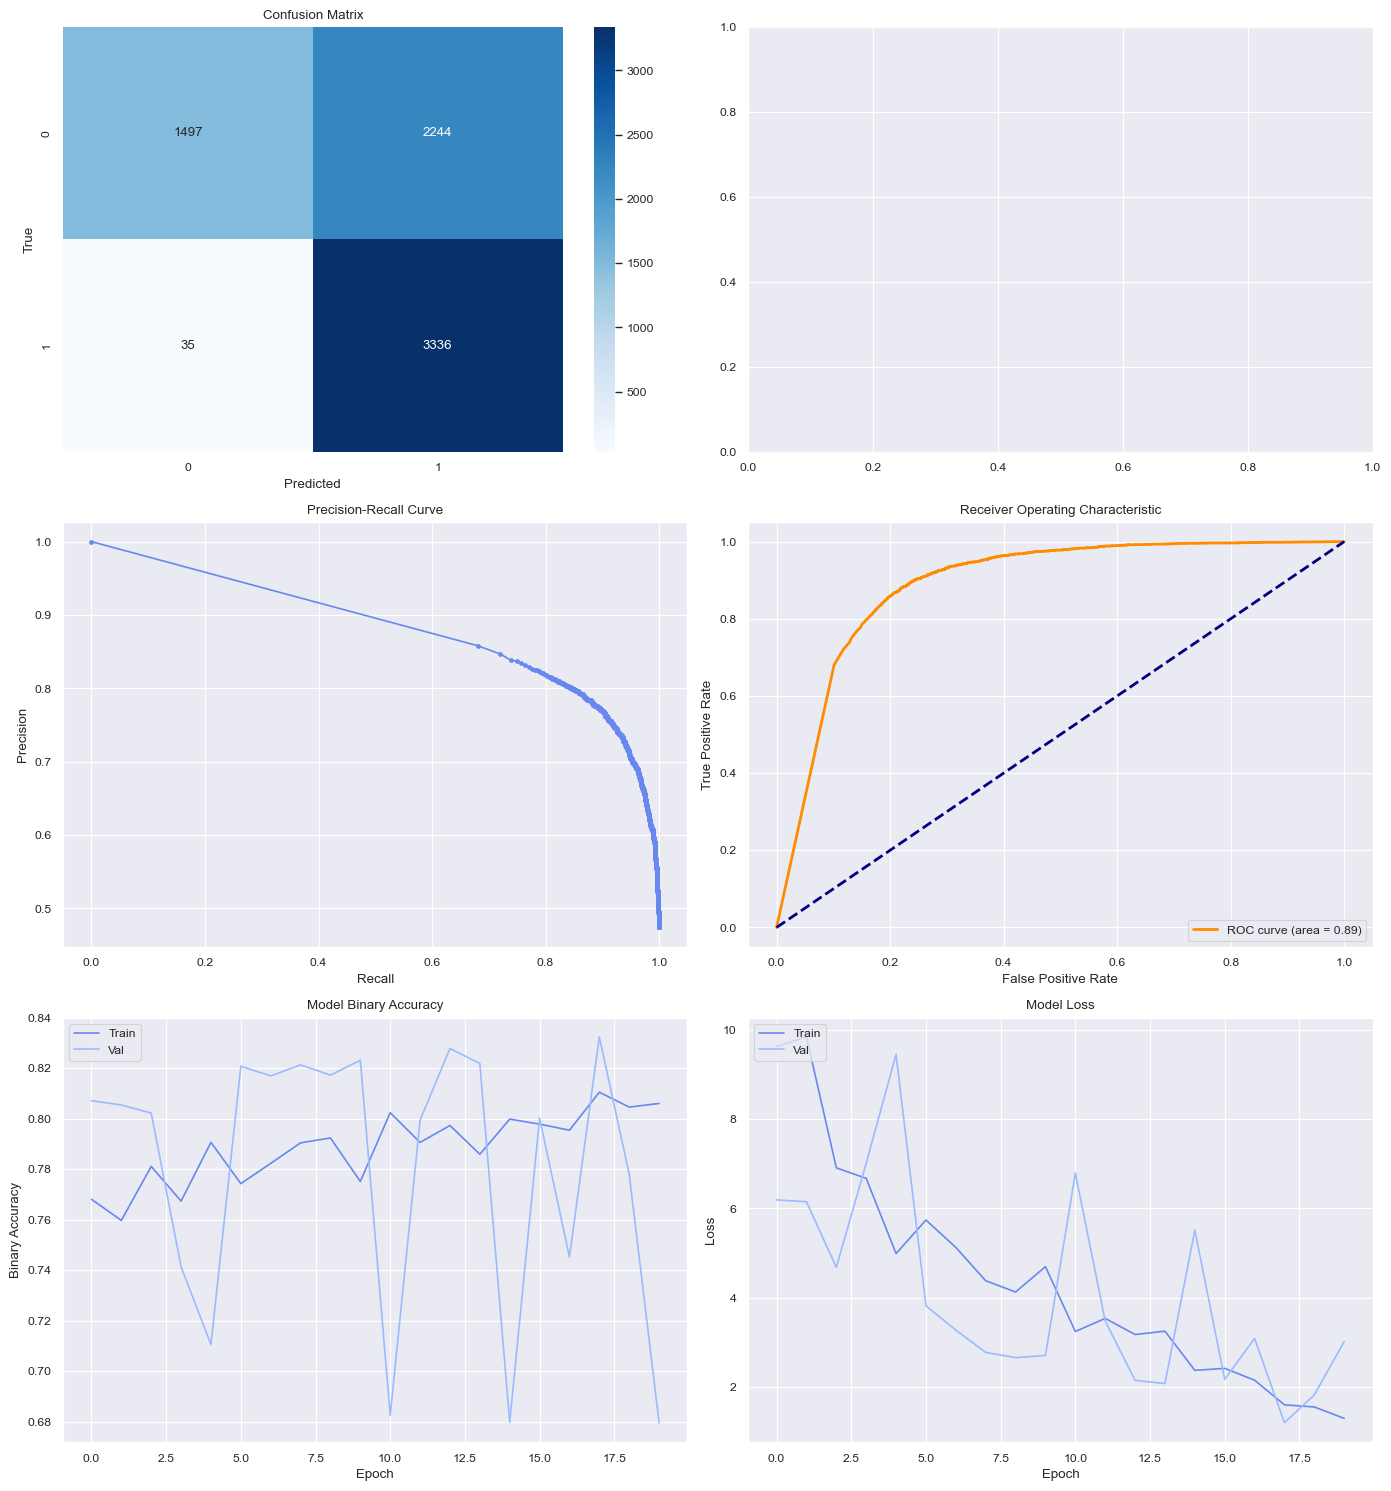

In [60]:
evaluate_neural_network(model, val_dataset_2, history_v2)

In [136]:
# Predict the labels for the validation set
y_pred_probs = model.predict(val_dataset_2)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

# Extract true labels from the validation dataset
y_true = np.concatenate([np.array([y.numpy()]) for x, y in val_dataset_2.unbatch()], axis=0)

# Print the classification report for all metrics
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

# Calculate and print the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


112/112 [==============================] - 34s 300ms/step
              precision    recall  f1-score   support

     Class 0       0.98      0.40      0.57      3741
     Class 1       0.60      0.99      0.75      3371

    accuracy                           0.68      7112
   macro avg       0.79      0.69      0.66      7112
weighted avg       0.80      0.68      0.65      7112

Accuracy: 67.96%


In [62]:
# Example usage:
calculate_combined_misclassification_info(
    y_true, 
    y_pred, 
    age_gender_data, 
    category_names=['age', 'ethnicity', 'gender']
)


age - Misclassification rates:
  0-4: Total = 1605, Misclassified = 501 (31.21%)
  10-14: Total = 589, Misclassified = 199 (33.79%)
  100-104: Total = 14, Misclassified = 4 (28.57%)
  105-109: Total = 5, Misclassified = 0 (0.00%)
  110-114: Total = 6, Misclassified = 2 (33.33%)
  115-119: Total = 7, Misclassified = 3 (42.86%)
  15-19: Total = 942, Misclassified = 295 (31.32%)
  20-24: Total = 2310, Misclassified = 732 (31.69%)
  25-29: Total = 1634, Misclassified = 543 (33.23%)

age - Misclassification distribution:
  0-4: Misclassified = 501 (21.98%) of Total Misclassified = 2279
  10-14: Misclassified = 199 (8.73%) of Total Misclassified = 2279
  100-104: Misclassified = 4 (0.18%) of Total Misclassified = 2279
  105-109: Misclassified = 0 (0.00%) of Total Misclassified = 2279
  110-114: Misclassified = 2 (0.09%) of Total Misclassified = 2279
  115-119: Misclassified = 3 (0.13%) of Total Misclassified = 2279
  15-19: Misclassified = 295 (12.94%) of Total Misclassified = 2279
  20-24:

## 7. We train our second model by tuning the hyper-parameters. Model 2 <a id="section7"></a>

* [Go back to index](#index)

#### 7.1 Model definition with hyper-parameters. Model 2 <a id="section71"></a>

* [Go back to index](#index)

##### The hyper-parameters we suggest are:

1. Activation functions: 'relu', 'tanh', 'sigmoid','leaky_relu'

2. Number of units (aka neurons): min_value=32, max_value=512

3. Learning rate: min_value=1e-4, max_value=1e-2

The opmitiser is Adam.

The loss function Binary Cross Entropy.

The metrics are Binary Accuracy and AUC.

In [69]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(48, 48, 1)))

    # Define hyperparameters for the dense layers
    for i in range(hp.Int('num_layers', 1, 4)):
        # Use a dynamic name for defining hyperparameters for each layer
        units_choice = hp.Int('units_' + str(i), min_value=32, max_value=512, step=32)
        activation_choice = hp.Choice('activation_' + str(i), values=['relu', 'tanh', 'sigmoid', 'leaky_relu','gelu'])
        model.add(keras.layers.Dense(units=units_choice, activation=activation_choice))

    # Output layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Hyperparameter for the optimizer choice
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd'])

    # Hyperparameters for the learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=hp.Float('momentum', 0.0, 0.9, step=0.1))

    # Loss function
    loss_function = keras.losses.BinaryCrossentropy()

    # Metrics
    metrics = [keras.metrics.BinaryAccuracy(threshold=0.5),
               keras.metrics.AUC()]

    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics)
    
    return model


#### 7.2 We instantiate the keras tuner with BayesianOptimization tuning with Gaussian process. Model 2 <a id="section72"></a>

* [Go back to index](#index)

https://keras.io/keras_tuner/

https://keras.io/api/keras_tuner/tuners/bayesian/

Bayesian Optimization is a type of model-based optimization algorithm that uses past evaluation results to form a probabilistic model mapping hyperparameters to a probability of a score on the objective function, which is then used to determine the next set of hyperparameters to evaluate.

- `build_model`: This is a function that returns a compiled model. The tuner will call this function with different combinations of hyperparameters to find the best model.

- ``objective='val_binary_accuracy'``: This is the metric that the tuner will optimize. In this case, it's the binary accuracy on the validation set.

- ``max_trials=10``: This is the maximum number of different hyperparameter combinations that the tuner will try.

- ``directory='keras_tuner_bayesian'``: This is the directory where the tuner will save its progress. This allows you to resume tuning later if needed.

- ``project_name='gender_classification'``: This is the name of the tuning project. It's used to organize different tuning runs in the directory.

- ``seed=42``: This is the random seed for reproducibility. It ensures that the tuner will produce the same results if run multiple times with the same inputs.

https://keras.io/api/callbacks/early_stopping/

The ``keras.callbacks.EarlyStopping`` function is used to create an instance of the EarlyStopping callback. This callback will stop the training process early if the model's performance on a validation metric stops improving for a certain number of epochs.

The ``patience`` parameter is used to specify the number of epochs with no improvement after which training will be stopped.

Gaussian Error Linear Unit (GELU), a high-performing neural network activation function. The GELU activation function is xΦ(x), where Φ(x) the standard Gaussian cumulative distribution function. The GELU nonlinearity weights inputs by their value, rather than gates inputs by their sign as in ReLUs (x1x>0). We perform an empirical evaluation of the GELU nonlinearity against the ReLU and ELU activations and find performance improvements across all considered computer vision, natural language processing, and speech tasks.

https://arxiv.org/abs/1606.08415

In [ ]:
FILENAME_MODEL="Model_2_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
FILEPATH_MODEL2 = os.path.join(current_working_directory, 'ckpt', FILENAME_MODEL)

model2ckpt_callback = tf.keras.callbacks.ModelCheckpoint(monitor="val_binary_accuracy",
                                                        filepath=FILEPATH_MODEL2,
                                                        verbose=1,
                                                        save_weights_only=False,
                                                        save_best_only=True)

In [70]:
import keras_tuner as kt
from tensorflow import keras
# Bayesian optimization tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_binary_accuracy',  # Change this if you want to optimize a different metric
    max_trials=20,  # Number of variations on the hyperparameters
    directory='keras_tuner_bayesian',
    project_name='gender_classification',
    seed=42  # Random seed for reproducibility
)

# Early stopping callback
stop_early = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5)

# Start the hyperparameter tuning process
tuner.search(train_dataset_1,
             epochs=3,
             validation_data=val_dataset_1,
             callbacks=[stop_early, model2ckpt_callback])



Trial 20 Complete [00h 05m 23s]
val_binary_accuracy: 0.5260123610496521

Best val_binary_accuracy So Far: 0.7695444226264954
Total elapsed time: 01h 46m 43s


KeyError: 'units does not exist.'

In [72]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Assuming you want to print out hyperparameters for all the dense layers
num_layers = best_hps.get('num_layers')
layers_info = []

for i in range(num_layers):
    units = best_hps.get(f'units_{i}')
    activation = best_hps.get(f'activation_{i}')
    layers_info.append(f"Layer {i+1}: {units} units, {activation} activation")

layers_info_str = "\n".join(layers_info)
learning_rate = best_hps.get('learning_rate')
optimizer = best_hps.get('optimizer')

print(f"""
The hyperparameter search is complete. Here are the optimal configurations for each layer:
{layers_info_str}
The optimal optimizer is {optimizer} with a learning rate of {learning_rate}.
""")



The hyperparameter search is complete. Here are the optimal configurations for each layer:
Layer 1: 416 units, gelu activation
Layer 2: 288 units, relu activation
The optimal optimizer is adam with a learning rate of 0.0003491260272208854.



In [83]:
# Build the model with the optimal hyperparameters and train it on the data
model_2 = tuner.hypermodel.build(best_hps)

In [87]:
print(type(best_hps))

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


In [90]:
# We print all the elements from best_hps
for element in best_hps.values:
    print(element)
    

num_layers
units_0
activation_0
optimizer
learning_rate
units_1
activation_1
units_2
activation_2
units_3
activation_3
momentum


In [92]:
#We print the actual value from each of the elements in best_hps
print(f'{Back.RED}num_layers:{Back.RESET}', f"{Back.BLUE}{best_hps.values['num_layers']}{Back.RESET}")
print(f'{Back.RED}units_0:{Back.RESET}', f"{Back.BLUE}{best_hps.values['units_0']}{Back.RESET}")
print(f'{Back.RED}activation_0:{Back.RESET}', f"{Back.BLUE}{best_hps.values['activation_0']}{Back.RESET}")
print(f'{Back.RED}units_1:{Back.RESET}', f"{Back.BLUE}{best_hps.values['units_1']}{Back.RESET}")
print(f'{Back.RED}activation_1:{Back.RESET}', f"{Back.BLUE}{best_hps.values['activation_1']}{Back.RESET}")
print(f'{Back.RED}units_2:{Back.RESET}', f"{Back.BLUE}{best_hps.values['units_2']}{Back.RESET}")
print(f'{Back.RED}activation_2:{Back.RESET}', f"{Back.BLUE}{best_hps.values['activation_2']}{Back.RESET}")
print(f'{Back.RED}units_3:{Back.RESET}', f"{Back.BLUE}{best_hps.values['units_3']}{Back.RESET}")
print(f'{Back.RED}activation_3:{Back.RESET}', f"{Back.BLUE}{best_hps.values['activation_3']}{Back.RESET}")
print(f'{Back.RED}learning_rate:{Back.RESET}', f"{Back.BLUE}{best_hps.values['learning_rate']}{Back.RESET}")
print(f'{Back.RED}optimizer:{Back.RESET}', f"{Back.BLUE}{best_hps.values['optimizer']}{Back.RESET}")


num_layers: 2
units_0: 416
activation_0: gelu
units_1: 288
activation_1: relu
units_2: 256
activation_2: leaky_relu
units_3: 128
activation_3: leaky_relu
learning_rate: 0.0003491260272208854
optimizer: adam


In [84]:
# Summarize the model
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2304)              0         
                                                                 
 dense_6 (Dense)             (None, 416)               958880    
                                                                 
 dense_7 (Dense)             (None, 288)               120096    
                                                                 
 dense_8 (Dense)             (None, 1)                 289       
                                                                 
Total params: 1,079,265
Trainable params: 1,079,265
Non-trainable params: 0
_________________________________________________________________


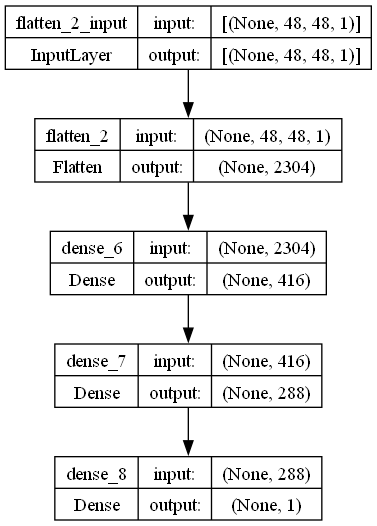

In [85]:
# Visualize the model
plot_model(model_2, show_shapes=True, show_layer_names=True, rankdir='TB')

#### 7.3 We train our model with the best hyper-parameters identified previously. Model 2  <a id="section73"></a>

* [Go back to index](#index)

1. The optimal number of units in the first densely-connected layer is 64 
2. The optimal activation function is leaky_relu.
3. The optimal learning rate for the optimizer is 0.008547485565344062.

In [78]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", min_delta=0, patience=5)

In [79]:
FILEPATH_MODEL2="model2_checkpoint.h5"

model2ckpt_callback = tf.keras.callbacks.ModelCheckpoint(monitor="val_binary_accuracy",
                                                        filepath=FILEPATH_MODEL2,
                                                        verbose=1,
                                                        save_weights_only=False,
                                                        save_best_only=True)


In [80]:
start_time = time.time()
history_v3 = model_2.fit(train_dataset_1, 
                         epochs=30, 
                         validation_data=val_dataset_1,
                         callbacks=[es_callback, model2ckpt_callback])
end_time = time.time()

Epoch 1/30


512/519 [============================>.] - ETA: 0s - loss: 21.4990 - binary_accuracy: 0.6985 - auc_1: 0.7102
Epoch 1: val_binary_accuracy improved from -inf to 0.63962, saving model to model2_checkpoint.h5
519/519 [==============================] - 106s 64ms/step - loss: 21.2842 - binary_accuracy: 0.6990 - auc_1: 0.7107 - val_loss: 9.0648 - val_binary_accuracy: 0.6396 - val_auc_1: 0.6919
Epoch 2/30
503/519 [============================>.] - ETA: 0s - loss: 3.3179 - binary_accuracy: 0.7279 - auc_1: 0.7645
Epoch 2: val_binary_accuracy improved from 0.63962 to 0.70993, saving model to model2_checkpoint.h5
519/519 [==============================] - 107s 64ms/step - loss: 3.2510 - binary_accuracy: 0.7292 - auc_1: 0.7664 - val_loss: 1.6189 - val_binary_accuracy: 0.7099 - val_auc_1: 0.8205
Epoch 3/30
498/519 [===========================>..] - ETA: 0s - loss: 1.4704 - binary_accuracy: 0.7464 - auc_1: 0.8041
Epoch 3: val_binary_accuracy did not improve from 0.70993
519/519 [====================

#### Training time. Model 2

In [81]:
# Calculate and print the duration
duration_mins = (end_time - start_time)/60
print(f'{Back.RED}Training completed in (mins):{Back.RESET}',
    f"\n{Back.BLUE}{duration_mins:.3f}{Back.RESET}")

Training completed in (mins): 
31.357


#### 7.4 We evaluate our model. Model 2 <a id="section74"></a>

* [Go back to index](#index)

```python 
y_pred_probs = model.predict(val_dataset_1)
```

The ``model.predict`` method is used to make predictions on the ``val_dataset_1`` validation dataset. This method returns a probability for each input sample, which represents the model's confidence that the sample belongs to the positive class. These probabilities are stored in the ``y_pred_probs`` variable.


```python 
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)
```

This is converting these probabilities into binary class labels. This is done by comparing the probabilities to a threshold of 0.5. If the probability is greater than 0.5, the predicted class label is 1 (the positive class); otherwise, the predicted class label is 0 (the negative class). 

The ``astype(int)`` method is used to convert the Boolean values (True and False) resulting from the comparison to integers (1 and 0). The ``reshape(-1)`` method is used to flatten the array of class labels into a 1D array.


In [93]:
model_2_trainned = keras.models.load_model(FILEPATH_MODEL2)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn-metrics-classification-report
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

223/223 [==============================] - 33s 148ms/step
              precision    recall  f1-score   support

     Class 0       0.89      0.76      0.82      3741
     Class 1       0.77      0.90      0.83      3371

    accuracy                           0.83      7112
   macro avg       0.83      0.83      0.83      7112
weighted avg       0.84      0.83      0.83      7112

Accuracy: 82.61%


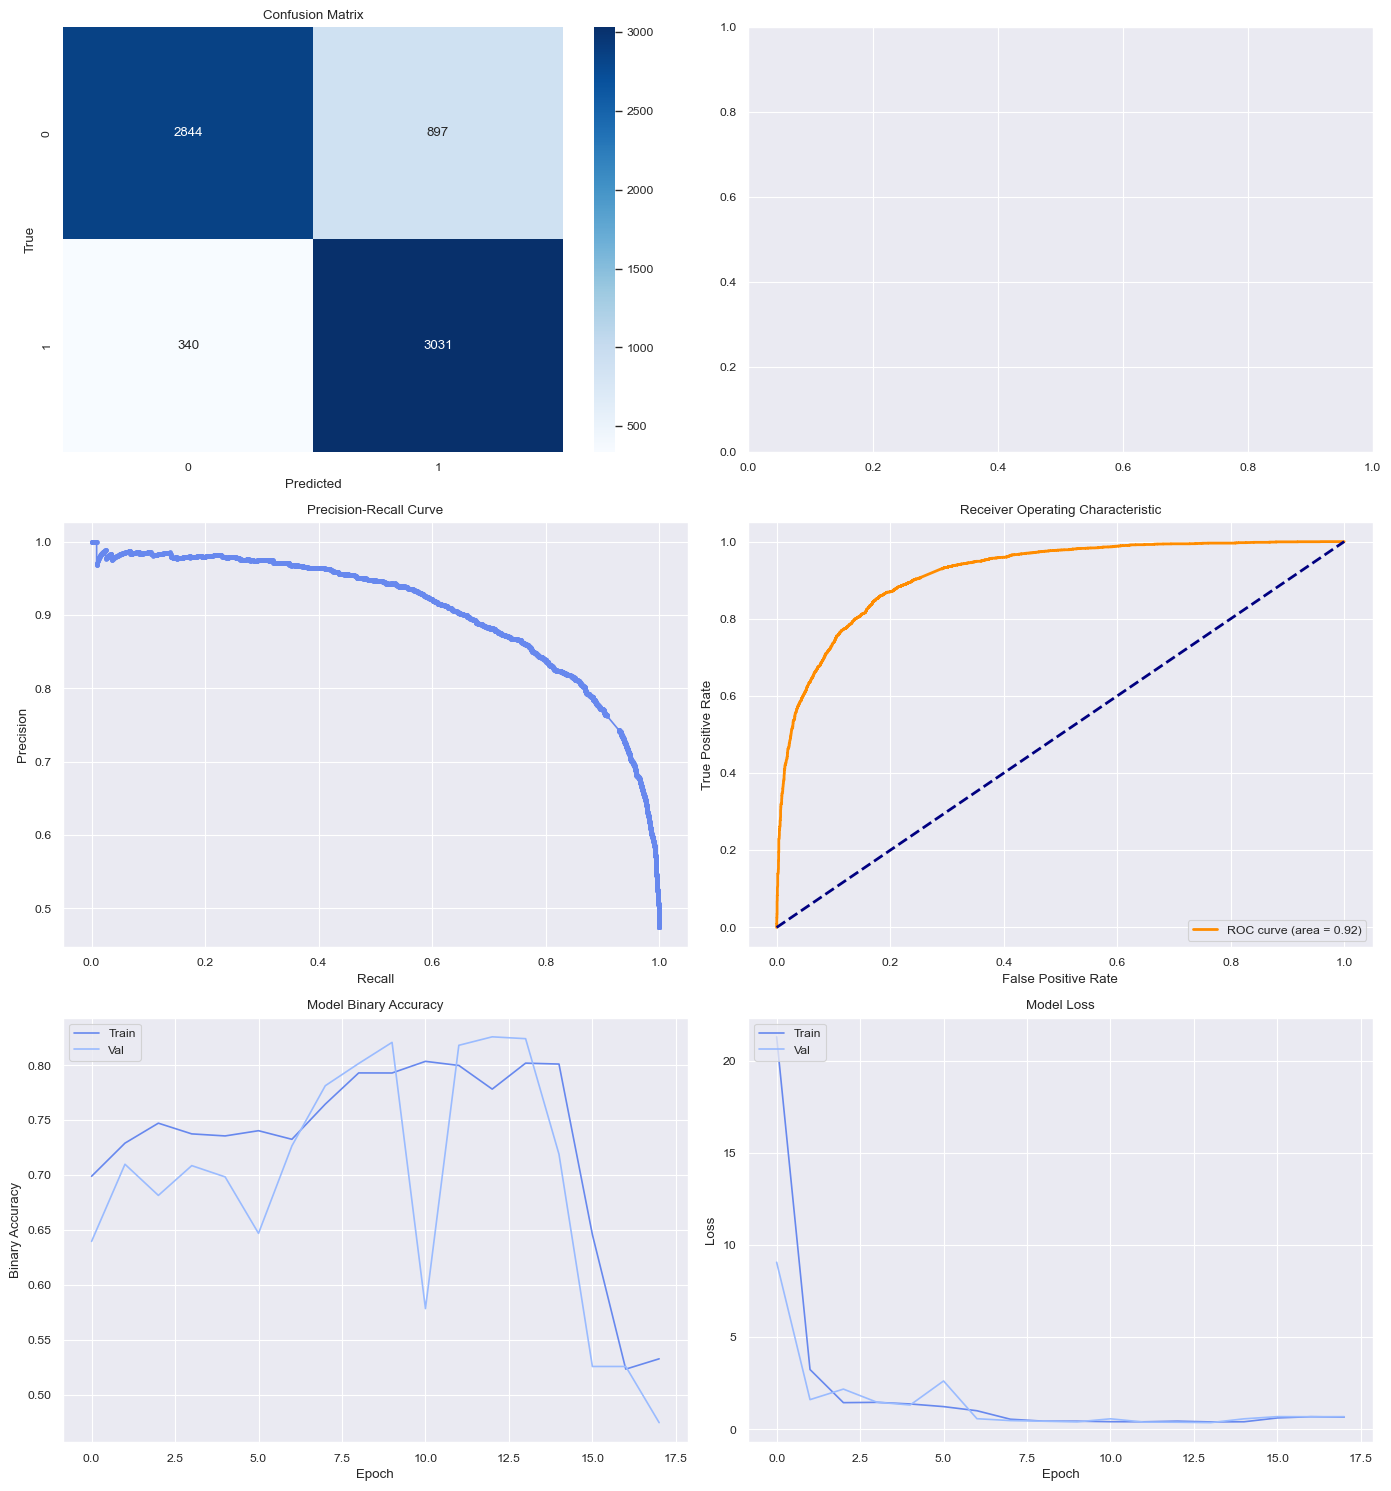

In [95]:
evaluate_neural_network(model_2_trainned, val_dataset_1, history_v3)

#### 7.5 We analyse the misclassification information where the misclassified instances are broken down by the original labels. Model 2 <a id="section75"></a>

* [Go back to index](#index)

1. gender - Misclassification rates (of the total instances how many have been misclassified broken down by gender):
  - 0: Total = 2648, Misclassified = 636 (24.02%)
  - 1: Total = 4464, Misclassified = 1057 (23.68%)

2. gender - Misclassification distribution (of the misclassified instance the distribution between the different values of gender):
  - 0: Misclassified = 636 (37.57%) of Total Misclassified = 1693
  - 1: Misclassified = 1057 (62.43%) of Total Misclassified = 1693

In [99]:
# Example usage:
calculate_combined_misclassification_info(
    y_true, 
    y_pred, 
    age_gender_data, 
    category_names=['age', 'ethnicity', 'gender']
)


age - Misclassification rates:
  0-4: Total = 1605, Misclassified = 260 (16.20%)
  10-14: Total = 589, Misclassified = 120 (20.37%)
  100-104: Total = 14, Misclassified = 0 (0.00%)
  105-109: Total = 5, Misclassified = 0 (0.00%)
  110-114: Total = 6, Misclassified = 0 (0.00%)
  115-119: Total = 7, Misclassified = 4 (57.14%)
  15-19: Total = 942, Misclassified = 178 (18.90%)
  20-24: Total = 2310, Misclassified = 378 (16.36%)
  25-29: Total = 1634, Misclassified = 297 (18.18%)

age - Misclassification distribution:
  0-4: Misclassified = 260 (21.02%) of Total Misclassified = 1237
  10-14: Misclassified = 120 (9.70%) of Total Misclassified = 1237
  100-104: Misclassified = 0 (0.00%) of Total Misclassified = 1237
  105-109: Misclassified = 0 (0.00%) of Total Misclassified = 1237
  110-114: Misclassified = 0 (0.00%) of Total Misclassified = 1237
  115-119: Misclassified = 4 (0.32%) of Total Misclassified = 1237
  15-19: Misclassified = 178 (14.39%) of Total Misclassified = 1237
  20-24: M

In [100]:
# List all data in history
print(history_v3.history.keys())

dict_keys(['loss', 'binary_accuracy', 'auc_1', 'val_loss', 'val_binary_accuracy', 'val_auc_1'])


## 8. We train our first RESNET Neural Network <a id="section8"></a>

* [Go back to index](#index)


In [115]:
def residual_block(x, filters, conv_size, stride, is_identity=True):
    """Builds a residual block with skip connections."""
    shortcut = x
    # First convolution layer
    x = layers.Conv2D(filters, conv_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second convolution layer
    x = layers.Conv2D(filters, conv_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Add the shortcut to the output of the convolution block
    if not is_identity:
        shortcut = layers.Conv2D(filters, conv_size, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def build_resnet_v2(input_shape, num_classes=1, layer_list=[2, 2, 2, 2, 2]):
    """Builds a ResNet model."""
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Add the residual blocks
    for i, num_blocks in enumerate(layer_list):
        for j in range(num_blocks):
            if j == 0 and i != 0:
                x = residual_block(x, 64 * 2**i, (3, 3), stride=2, is_identity=False)
            else:
                x = residual_block(x, 64 * 2**i, (3, 3), stride=1)

    x = layers.GlobalAveragePooling2D()(x)
    
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)  # For binary classification.
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [116]:
# Build the ResNet model
input_shape = (48, 48, 1)  # Adjust if your preprocessing changes the input shape.
model_resnet_v2 = build_resnet_v2(input_shape)

In [117]:
model_resnet_v2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_25 (Conv2D)             (None, 24, 24, 64)   3200        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_25 (BatchN  (None, 24, 24, 64)  256         ['conv2d_25[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_21 (Activation)     (None, 24, 24, 64)   0           ['batch_normalization_25[0]

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

In [118]:
# Using Adam as a more adaptive optimizer
ADAM_OPTIM = tf.keras.optimizers.Adam(learning_rate=0.001)

https://keras.io/api/losses/probabilistic_losses/#binary_crossentropy-function

In [121]:
BIN_CROSS_ENT = tf.keras.losses.BinaryCrossentropy()

https://keras.io/api/metrics/classification_metrics/#f1score-class


In [119]:
METRICS = [keras.metrics.BinaryAccuracy(threshold=0.5),
           keras.metrics.AUC(),
           keras.metrics.Precision(),
           keras.metrics.Recall(),
           keras.metrics.TruePositives(),
           keras.metrics.TrueNegatives(),
           keras.metrics.FalsePositives(),
           keras.metrics.FalseNegatives()]

The `model.compile` method is used to configure the learning process before training the model. It takes three main arguments: an optimizer, a loss function, and a list of metrics.

In [122]:
# Compile the model
model_resnet_v2.compile(optimizer=ADAM_OPTIM, loss=BIN_CROSS_ENT, metrics=METRICS)

In [123]:
FILENAME_MODEL="Model_RESNET2_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
FILEPATH_MODEL_RESNET2 = os.path.join(current_working_directory, 'ckpt', FILENAME_MODEL)

model2ckpt_callback = tf.keras.callbacks.ModelCheckpoint(monitor="val_binary_accuracy",
                                                        filepath=FILEPATH_MODEL_RESNET2,
                                                        verbose=1,
                                                        save_weights_only=False,
                                                        save_best_only=True)

In [124]:
# Train the model on your dataset
start_time = time.time()
history_v5 = model_resnet_v2.fit(train_dataset_1, 
                         epochs=30, 
                         validation_data=val_dataset_1,
                         callbacks=[es_callback, model2ckpt_callback])
end_time = time.time()

Epoch 1/30


519/519 [==============================] - ETA: 0s - loss: 0.5043 - binary_accuracy: 0.7809 - auc_3: 0.8618 - precision: 0.7731 - recall: 0.7676 - true_positives: 6097.0000 - true_negatives: 6861.0000 - false_positives: 1789.0000 - false_negatives: 1846.0000
Epoch 1: val_binary_accuracy improved from -inf to 0.76504, saving model to c:\Users\fercv\OneDrive\Desktop\AI_Master_Degree\5_Deep_Learning\DL_Computer_Vision_Keras\ckpt\Model_RESNET2_weights.01-0.49.hdf5
519/519 [==============================] - 156s 144ms/step - loss: 0.5043 - binary_accuracy: 0.7809 - auc_3: 0.8618 - precision: 0.7731 - recall: 0.7676 - true_positives: 6097.0000 - true_negatives: 6861.0000 - false_positives: 1789.0000 - false_negatives: 1846.0000 - val_loss: 0.4881 - val_binary_accuracy: 0.7650 - val_auc_3: 0.9106 - val_precision: 0.9134 - val_recall: 0.5571 - val_true_positives: 1878.0000 - val_true_negatives: 3563.0000 - val_false_positives: 178.0000 - val_false_negatives: 1493.0000
Epoch 2/30
519/519 [=====

In [133]:
# List all data in history
print(history_v5.history.keys())

dict_keys(['loss', 'binary_accuracy', 'auc_3', 'precision', 'recall', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives', 'val_loss', 'val_binary_accuracy', 'val_auc_3', 'val_precision', 'val_recall', 'val_true_positives', 'val_true_negatives', 'val_false_positives', 'val_false_negatives'])


In [125]:
# Calculate and print the duration
duration_mins = (end_time - start_time)/60
print(f'{Back.RED}Training completed in (mins):{Back.RESET}',
    f"\n{Back.BLUE}{duration_mins:.3f}{Back.RESET}")

Training completed in (mins): 
42.226


In [127]:
FILE_TRAINED = 'Model_RESNET2_weights.12-0.31.hdf5'
FILEPATH_MODEL_RESNET2 = os.path.join(current_working_directory, 'ckpt', FILE_TRAINED)
model_RESNET2_trainned = keras.models.load_model(FILEPATH_MODEL_RESNET2)

223/223 [==============================] - 32s 141ms/step
              precision    recall  f1-score   support

     Class 0       0.89      0.91      0.90      3741
     Class 1       0.89      0.87      0.88      3371

    accuracy                           0.89      7112
   macro avg       0.89      0.89      0.89      7112
weighted avg       0.89      0.89      0.89      7112

Accuracy: 89.05%


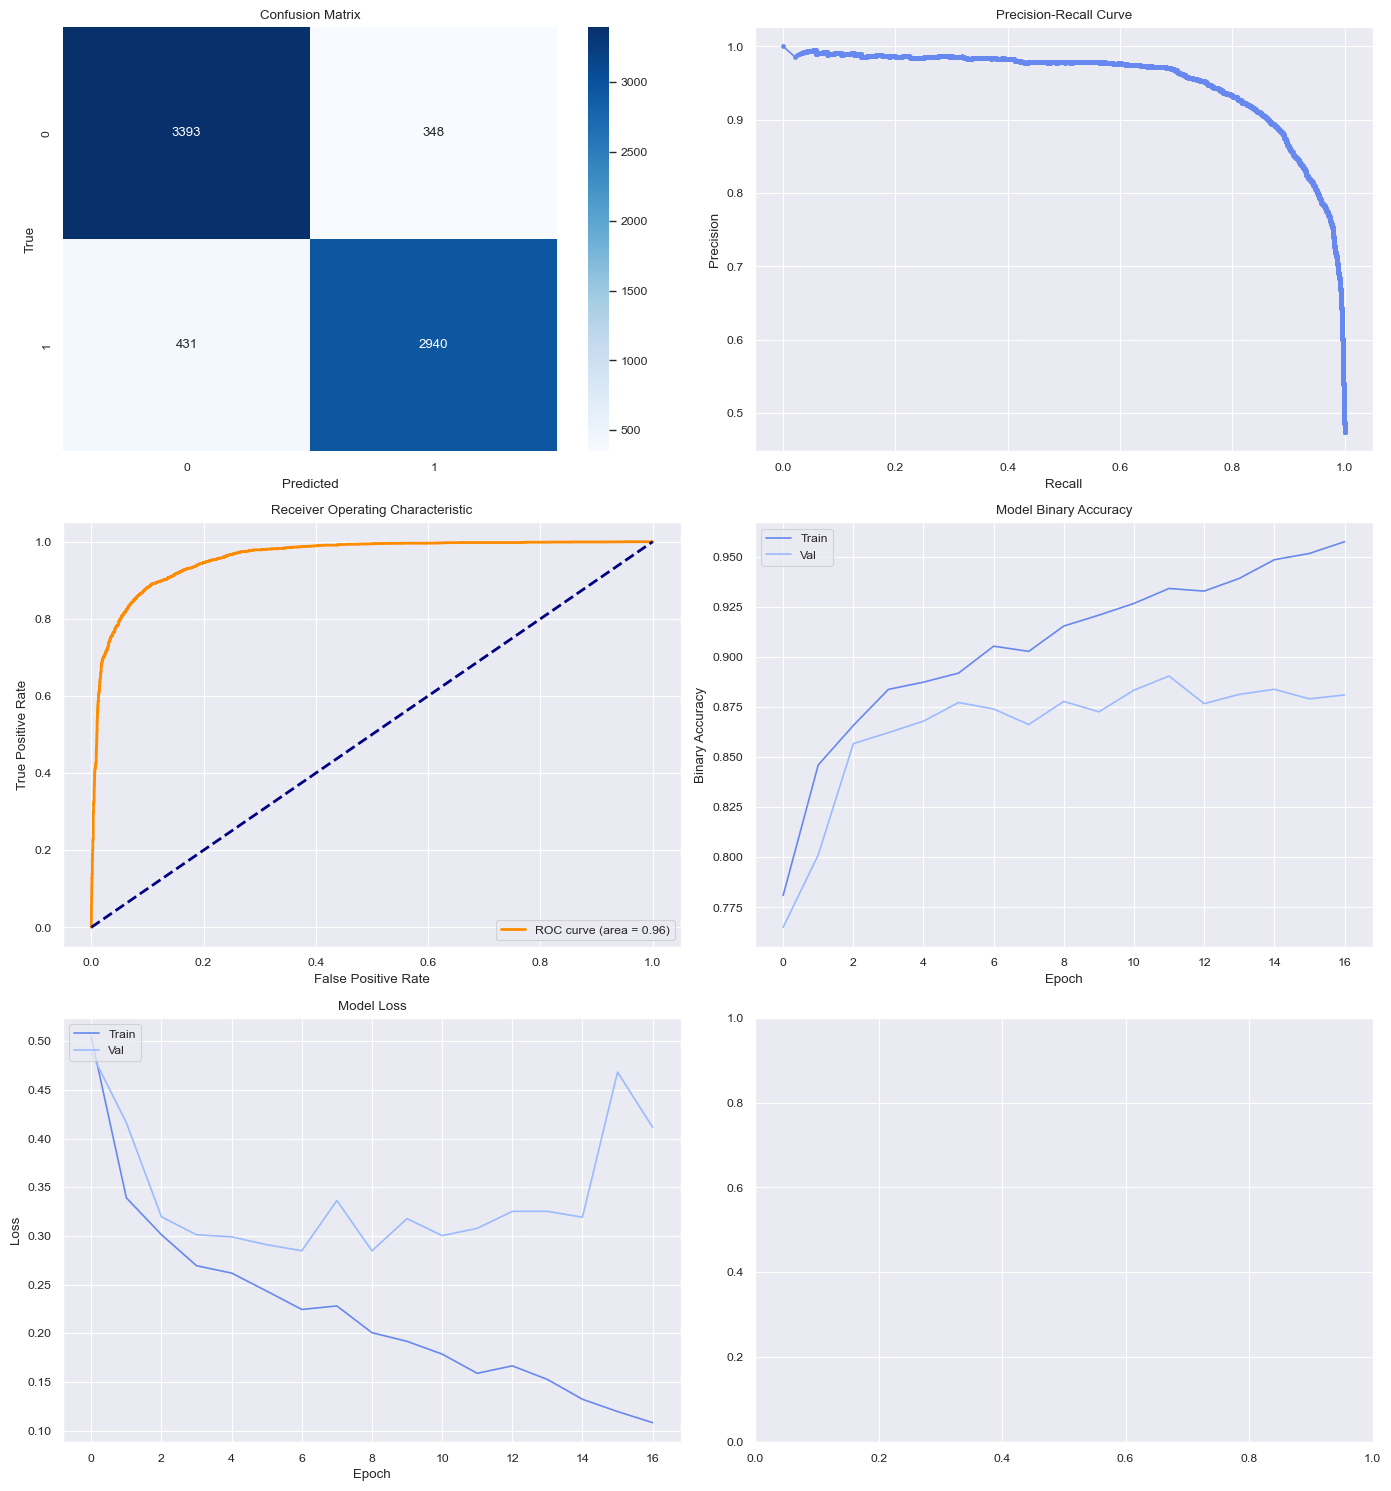

In [138]:
evaluate_neural_network(model_RESNET2_trainned, val_dataset_1, history_v5)

In [140]:
y_pred_probs = model_RESNET2_trainned.predict(val_dataset_1)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)
y_true = np.concatenate([np.array([y.numpy()]) for x, y in val_dataset_1.unbatch()], axis=0)

calculate_combined_misclassification_info(
    y_true, 
    y_pred, 
    age_gender_data, 
    category_names=['age', 'ethnicity', 'gender']
)

223/223 [==============================] - 33s 146ms/step

age - Misclassification rates:
  0-4: Total = 1605, Misclassified = 171 (10.65%)
  10-14: Total = 589, Misclassified = 79 (13.41%)
  100-104: Total = 14, Misclassified = 1 (7.14%)
  105-109: Total = 5, Misclassified = 0 (0.00%)
  110-114: Total = 6, Misclassified = 0 (0.00%)
  115-119: Total = 7, Misclassified = 2 (28.57%)
  15-19: Total = 942, Misclassified = 127 (13.48%)
  20-24: Total = 2310, Misclassified = 231 (10.00%)
  25-29: Total = 1634, Misclassified = 168 (10.28%)

age - Misclassification distribution:
  0-4: Misclassified = 171 (21.95%) of Total Misclassified = 779
  10-14: Misclassified = 79 (10.14%) of Total Misclassified = 779
  100-104: Misclassified = 1 (0.13%) of Total Misclassified = 779
  105-109: Misclassified = 0 (0.00%) of Total Misclassified = 779
  110-114: Misclassified = 0 (0.00%) of Total Misclassified = 779
  115-119: Misclassified = 2 (0.26%) of Total Misclassified = 779
  15-19: Misclassified = 12

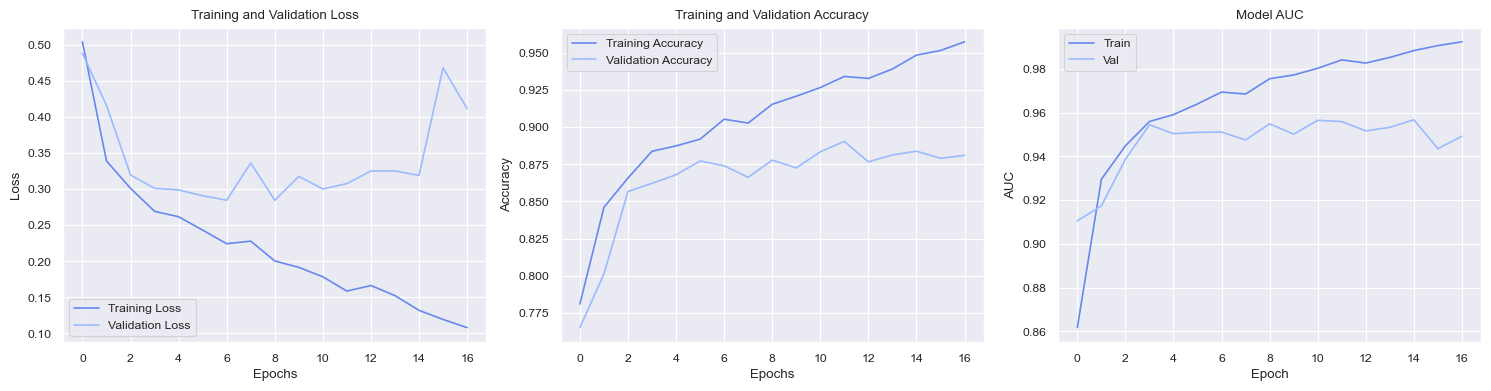

In [134]:
# Plotting training and validation loss
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(history_v5.history['loss'], label='Training Loss')
plt.plot(history_v5.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(history_v5.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history_v5.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_v5.history['auc_3'])
plt.plot(history_v5.history['val_auc_3'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()